In [2]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
udev            213G     0  213G   0% /dev
tmpfs            43G  4.1G   39G  10% /run
/dev/sda1        62G   32G   31G  51% /
tmpfs           213G  212K  213G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
tmpfs           213G     0  213G   0% /sys/fs/cgroup
/dev/sdb1       851G   75G  733G  10% /mnt
tmpfs            43G  316K   43G   1% /run/user/1000


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import sklearn
from sklearn import metrics
import sklearn.model_selection
import datetime
import time
import os
import math
random.seed(1)
%matplotlib inline

In [4]:
import multiprocessing as mp
mp.cpu_count()

64

In [5]:
DATA_FOLDER = 'LendingClub Dataset 2017Q1'
# TARGET_NAME = 'Status'

df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'df_train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'df_test.csv'), index_col=0)
df_train.shape
df_test.shape

(19999, 145)

(5000, 145)

In [6]:
default_definition = ["Default", 
                      "Charged Off", 
                      "In Grace Period",
                      "Late (16-30 days)", 
                      "Late (31-120 days)"]

In [7]:
df_train['default'] = df_train['loan_status'].isin(default_definition)*1
df_test['default'] = df_test['loan_status'].isin(default_definition)*1
df_train['default'].mean()
df_test['default'].mean()

0.07720386019300965

0.0698

In [8]:
# fields = ["term",
# "int_rate",
# "grade",
# "emp_length" ,
# "home_ownership",
# "annual_inc",
# "verification_status",
# "issue_d",
# "pymnt_plan" ,
# "purpose" ,
# # "addr_state" ,
# "dti",
# "delinq_2yrs",
# "earliest_cr_line" ,
# "inq_last_6mths",
# "open_acc",
# "pub_rec" ,
# "revol_bal",
# "revol_util",
# "initial_list_status" ,
# "out_prncp_inv" ,
# "total_rec_late_fee" ,
# "collection_recovery_fee" ,
# "last_pymnt_d",
# "last_pymnt_amnt" ,
# "last_credit_pull_d",
# "collections_12_mths_ex_med" ,
# "mths_since_last_major_derog" ,
# "application_type" ,
# "acc_now_delinq",
# "tot_coll_amt" ,
# "tot_cur_bal",
# "default"]
# df_train = df_train[fields]
# df_test = df_test[fields]

In [9]:
fields = ["term", "grade", "emp_length", "home_ownership", "annual_inc",
    "purpose", "pymnt_plan", "out_prncp_inv", "delinq_2yrs", 'default']
df_train = df_train[fields]
df_test = df_test[fields]

In [10]:
df_test.head()

,term,grade,emp_length,home_ownership,annual_inc,purpose,pymnt_plan,out_prncp_inv,delinq_2yrs,default
31360,60 months,B,10+ years,RENT,72000.0,debt_consolidation,n,14476.82,0.0,0
15275,60 months,C,10+ years,MORTGAGE,200000.0,credit_card,n,17160.76,0.0,0
77068,60 months,C,10+ years,MORTGAGE,135000.0,debt_consolidation,n,27625.14,0.0,0
90199,36 months,B,NaN,MORTGAGE,76000.0,debt_consolidation,n,14748.82,1.0,0
81687,60 months,B,10+ years,MORTGAGE,650000.0,credit_card,n,22334.61,0.0,0


In [11]:
df_test.shape

(5000, 10)

In [12]:
for col in df_train.columns:
    col, df_train[col].unique()

('term', array([' 36 months', ' 60 months'], dtype=object))

('grade', array(['C', 'B', 'D', 'E', 'A', 'F', 'G'], dtype=object))

('emp_length',
 array(['2 years', '3 years', '9 years', '4 years', '10+ years', nan,
        '< 1 year', '5 years', '1 year', '7 years', '6 years', '8 years'],
       dtype=object))

('home_ownership', array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object))

('annual_inc',
 array([100000.,  33600.,  34000., ...,  22080.,  81563.,  21170.]))

('purpose',
 array(['debt_consolidation', 'credit_card', 'other', 'home_improvement',
        'medical', 'major_purchase', 'moving', 'car', 'small_business',
        'house', 'vacation', 'renewable_energy'], dtype=object))

('pymnt_plan', array(['n', 'y'], dtype=object))

('out_prncp_inv',
 array([12812.61,     0.  ,  3746.04, ...,  4168.05,  2399.33,  6688.59]))

('delinq_2yrs',
 array([ 0.,  1.,  2.,  3.,  5.,  4., 19.,  7.,  6., 10.,  8., 11.,  9.,
        15., 12., 18.]))

('default', array([0, 1]))

In [13]:
# categ_features = ['home_ownership','purpose','addr_state', 'verification_status']
# categ_features = ['home_ownership','purpose', 'verification_status']
categ_features = ['home_ownership','purpose']

In [14]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(df_train[categ_features])

df_train_categ = pd.DataFrame(ohe.transform(df_train[categ_features])).astype(int)
df_test_categ = pd.DataFrame(ohe.transform(df_test[categ_features])).astype(int)
df_train_categ.shape
df_test_categ.shape

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False)

(19999, 16)

(5000, 16)

In [15]:
for i in df_train_categ.columns:
    df_train[i] = df_train_categ.values.astype(int)[:,i]
    df_test[i] = df_test_categ.values.astype(int)[:,i]

In [16]:
df_train.drop(categ_features, axis=1, inplace=True)
df_test.drop(categ_features, axis=1, inplace=True)

In [17]:
term_dict_repl = {
    ' 36 months':36, 
    ' 60 months':60    
}

grade_dict_repl = {
    'C':3, 
    'B':2,
    'D':4,
    'E':5,
    'A':1,
    'F':6,
    'G':7
}

emp_length_dict_repl = {
    '2 years':2,
    '3 years':3, 
    '9 years':9,
    '4 years':4,
    '10+ years':10,
    '< 1 year':0,
    '5 years':5,
    '1 year':1,
    '7 years':7,
    '6 years':6,
    '8 years':8
}

pymnt_plan_dict_repl = {
    'n':0, 
    'y':1,
}

application_type_dict_repl = {
    'Individual':1, 
    'Joint App':2    
}

initial_list_status_dict_repl = {
    'w':0, 
    'f':1,
}


In [18]:
# df_train['int_rate'] = df_train['int_rate'].str.strip(' %').astype(np.float32)
# df_test['int_rate'] = df_test['int_rate'].str.strip(' %').astype(np.float32)
# df_train['revol_util'] = df_train['revol_util'].str.strip(' %').astype(np.float32)
# df_test['revol_util'] = df_test['revol_util'].str.strip(' %').astype(np.float32)
df_train['term'] = df_train['term'].replace(term_dict_repl).astype(np.float32)
df_test['term'] = df_test['term'].replace(term_dict_repl).astype(np.float32)
df_train['grade'] = df_train['grade'].replace(grade_dict_repl).astype(np.float32)
df_test['grade'] = df_test['grade'].replace(grade_dict_repl).astype(np.float32)
df_train['emp_length'] = df_train['emp_length'].replace(emp_length_dict_repl).astype(np.float32)
df_test['emp_length'] = df_test['emp_length'].replace(emp_length_dict_repl).astype(np.float32)
df_train['pymnt_plan'] = df_train['pymnt_plan'].replace(pymnt_plan_dict_repl).astype(np.float32)
df_test['pymnt_plan'] = df_test['pymnt_plan'].replace(pymnt_plan_dict_repl).astype(np.float32)
# df_train['application_type'] = df_train['application_type'].replace(application_type_dict_repl).astype(np.float32)
# df_test['application_type'] = df_test['application_type'].replace(application_type_dict_repl).astype(np.float32)
# df_train['initial_list_status'] = df_train['initial_list_status'].replace(initial_list_status_dict_repl).astype(np.float32)
# df_test['initial_list_status'] = df_test['initial_list_status'].replace(initial_list_status_dict_repl).astype(np.float32)

In [19]:
df_test.head()

,term,grade,emp_length,annual_inc,pymnt_plan,out_prncp_inv,delinq_2yrs,default,0,1,...,6,7,8,9,10,11,12,13,14,15
31360,60.0,2.0,10.0,72000.0,0.0,14476.82,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15275,60.0,3.0,10.0,200000.0,0.0,17160.76,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
77068,60.0,3.0,10.0,135000.0,0.0,27625.14,0.0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
90199,36.0,2.0,NaN,76000.0,0.0,14748.82,1.0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
81687,60.0,2.0,10.0,650000.0,0.0,22334.61,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# date_features = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']

# df_train.drop(date_features, axis=1, inplace=True)
# df_test.drop(date_features, axis=1, inplace=True)

In [21]:
TARGET_NAME = 'default'
y_train = df_train[TARGET_NAME]
y_test = df_test[TARGET_NAME]

df_train_pos = df_train[df_train[TARGET_NAME]==1].drop(TARGET_NAME,axis=1)
df_train_neg = df_train[df_train[TARGET_NAME]==0].drop(TARGET_NAME,axis=1)
df_test_pos = df_test[df_test[TARGET_NAME]==1].drop(TARGET_NAME,axis=1)
df_test_neg = df_test[df_test[TARGET_NAME]==0].drop(TARGET_NAME,axis=1)

df_train_pos.head()

,term,grade,emp_length,annual_inc,pymnt_plan,out_prncp_inv,delinq_2yrs,0,1,2,...,6,7,8,9,10,11,12,13,14,15
54042,36.0,4.0,NaN,20000.0,0.0,0.00,1.0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
17149,36.0,3.0,0.0,72000.0,0.0,0.00,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15736,36.0,4.0,10.0,60000.0,0.0,0.00,1.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2771,60.0,3.0,2.0,155000.0,0.0,25895.44,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26871,36.0,3.0,1.0,83000.0,0.0,24844.25,0.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
df_train_pos.to_csv(os.path.join(DATA_FOLDER, 'df_train_pos.csv'))
df_train_neg.to_csv(os.path.join(DATA_FOLDER, 'df_train_neg.csv'))

In [23]:
df_train_pos = pd.read_csv(os.path.join(DATA_FOLDER, 'df_train_pos.csv'),index_col=0)
df_train_neg = pd.read_csv(os.path.join(DATA_FOLDER, 'df_train_neg.csv'),index_col=0)

In [24]:
df_train_pos.head()

,term,grade,emp_length,annual_inc,pymnt_plan,out_prncp_inv,delinq_2yrs,0,1,2,...,6,7,8,9,10,11,12,13,14,15
54042,36.0,4.0,NaN,20000.0,0.0,0.00,1.0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
17149,36.0,3.0,0.0,72000.0,0.0,0.00,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15736,36.0,4.0,10.0,60000.0,0.0,0.00,1.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2771,60.0,3.0,2.0,155000.0,0.0,25895.44,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26871,36.0,3.0,1.0,83000.0,0.0,24844.25,0.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [25]:
df_train_pos.columns

Index(['term', 'grade', 'emp_length', 'annual_inc', 'pymnt_plan',
       'out_prncp_inv', 'delinq_2yrs', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15'],
      dtype='object')

In [26]:
df_train.drop('default', axis=1, inplace=True)
df_test.drop('default', axis=1, inplace=True)

In [27]:
X_pos = df_train_pos.values
X_neg = df_train_neg.values
X_test = df_test.values

#### ConceptMiner


In [106]:
def nunique_percol_sort(a):
    """Number of unique values in a row of array"""
    b = np.sort(a,axis=1)
    return (b[:,1:] != b[:,:-1]).sum(axis=1)+1

class PatternStructuresMiner():
    """
    Basic class to explore intersections of objects and build hypotheses
    """
    def __init__(self, data_pos, data_neg, feature_list):
        """
        :param data_pos: Pandas.DataFrame with objects from class 1
        :param data_neg: Pandas.DataFrame with objects from class 0
        :param feature_list: list of column names used as features
        """
        self.data_pos = data_pos[feature_list]
        self.data_neg = data_neg[feature_list]
        self.X_pos_expanded = np.expand_dims(self.data_pos.values, 0)
        self.X_neg_expanded = np.expand_dims(self.data_neg.values, 0)
        self.feature_list = feature_list
        self.is_nan_X_pos_expanded = np.isnan(self.X_pos_expanded)
        self.is_nan_X_neg_expanded = np.isnan(self.X_neg_expanded)
    
    def mine_obj_intersections(self, n_obj, subs_size, concepts_type):
        # np.random.choice is too slow
        print("Mining {} intersections".format(n_obj))
        data = self.data_pos if concepts_type == 'pos' else self.data_neg
        indexes = np.random.randint(0, data.shape[0], size=(n_obj, subs_size))

        # provide objects in subsamples are unique
        n_unique = nunique_percol_sort(indexes)
        indexes = indexes[n_unique == subs_size]
        
        # left & right borders of interval pattern structures
        concepts_min = np.expand_dims(np.nanmin(data.values[indexes], axis=1), 1)
        concepts_max = np.expand_dims(np.nanmax(data.values[indexes], axis=1), 1)

        # 
        num_neg_objs_in_concepts = ((((concepts_min <= self.X_neg_expanded) | np.isnan(concepts_min)) & 
                                    ((concepts_max >= self.X_neg_expanded) | np.isnan(concepts_max))) | 
                                    self.is_nan_X_neg_expanded).all(axis=2).sum(axis=1)
        num_pos_objs_in_concepts = ((((concepts_min <= self.X_pos_expanded) | np.isnan(concepts_min)) & 
                                    ((concepts_max >= self.X_pos_expanded) | np.isnan(concepts_max))) | 
                                    self.is_nan_X_pos_expanded).all(axis=2).sum(axis=1)
        
        # stats
        pos_support = num_pos_objs_in_concepts / self.data_pos.shape[0]
        neg_support = num_neg_objs_in_concepts / self.data_neg.shape[0]
        pos_confidence = num_pos_objs_in_concepts / (num_pos_objs_in_concepts + num_neg_objs_in_concepts) 
        neg_confidence = num_neg_objs_in_concepts / (num_pos_objs_in_concepts + num_neg_objs_in_concepts) 
        
#         print("Mining obj Finished")
        return concepts_min[:,0,:], concepts_max[:,0,:], \
                pd.DataFrame({'N_pos_in_concepts':num_pos_objs_in_concepts,
                              'N_neg_in_concepts':num_neg_objs_in_concepts,
                              'concepts_type':[concepts_type]*num_pos_objs_in_concepts.shape[0],
                              'subs_size':[subs_size]*num_pos_objs_in_concepts.shape[0],
                              'N_pos_all':[self.data_pos.shape[0]]*num_pos_objs_in_concepts.shape[0],
                              'N_neg_all':[self.data_neg.shape[0]]*num_pos_objs_in_concepts.shape[0],
                              'pos_support' : pos_support,
                              'neg_support' : neg_support,
                              'pos_confidence' : pos_confidence,
                              'neg_confidence' : neg_confidence
                               })
    
    
    def mine_hypotheses(self, alpha, hypo_type, subs_size,
                      N_hypo_need = None, N_iterations = None, batch_size = 1000, save_path = None):
        N_mined_hypo = 0
        hypotheses_min_LIST = []
        hypotheses_max_LIST = []
        iter_total = 0
        
        while N_mined_hypo < N_hypo_need:
            concepts_min, concepts_max, stats_concepts = self.mine_obj_intersections(batch_size, subs_size, hypo_type)
            good_hypos_idxs = stats_concepts.query(hypo_type + "_confidence >= " + str(alpha)).index
            hypotheses_min_LIST.append(concepts_min[good_hypos_idxs])
            hypotheses_max_LIST.append(concepts_max[good_hypos_idxs])
            N_mined_hypo += good_hypos_idxs.shape[0]
            print("N_mined_hypos of type " + hypo_type, N_mined_hypo)
            iter_total += batch_size
            if N_iterations and iter_total >= N_iterations:
                break
            
        hypotheses_min = np.concatenate(hypotheses_min_LIST)
        hypotheses_max = np.concatenate(hypotheses_max_LIST)
        if N_hypo_need:
            hypotheses_min = hypotheses_min[:N_hypo_need]
            hypotheses_max = hypotheses_max[:N_hypo_need]
        
        if save_path:
            pd.DataFrame(hypotheses_min).to_csv(os.path.join(save_path, "hypotheses_min.csv"), header=None, index=None)
            pd.DataFrame(hypotheses_max).to_csv(os.path.join(save_path, "hypotheses_max.csv"), header=None, index=None)
        
        return hypotheses_min, hypotheses_max
        


In [107]:
# features = ['term', 'int_rate', 'grade', 'emp_length', 'annual_inc', 'pymnt_plan',
#        'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
#        'revol_bal', 'revol_util', 'initial_list_status', 'out_prncp_inv',
#        'total_rec_late_fee', 'collection_recovery_fee', 'last_pymnt_amnt',
#        'collections_12_mths_ex_med', 'mths_since_last_major_derog',
#        'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
#        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
#        '13', '14', '15', '16', '17', '18']
features = ['term', 'grade', 'emp_length', 'annual_inc', 'pymnt_plan',
       'out_prncp_inv', 'delinq_2yrs', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15']

In [108]:
len(features)

23

In [109]:
%%time
PSM = PatternStructuresMiner(df_train_pos, df_train_neg, features)

CPU times: user 6.38 ms, sys: 3.08 ms, total: 9.47 ms
Wall time: 7.95 ms


In [110]:
# %%time
# _, _, stats_concepts_pos = PSM.mine_obj_intersections(10000, 3, 'pos')
# _, _, stats_concepts_neg = PSM.mine_obj_intersections(10000, 3, 'neg')

In [111]:
# import shutil
# folder = os.path.join(DATA_FOLDER, 'Hypotheses')
# shutil.rmtree(folder)
# os.mkdir(folder)

### Mine positive hypotheses

Mining 1000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


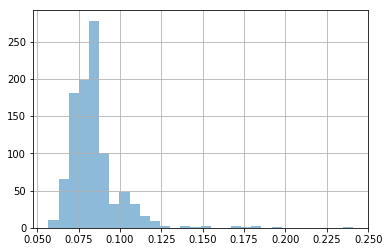

In [345]:
_, _, stats_concepts_pos = PSM.mine_obj_intersections(1000, 10, 'pos')
stats_concepts_pos['pos_confidence'].hist(alpha = 0.5, bins = 30)

In [370]:
%%time
subs_alpha_dict = {
    2:np.linspace(0,1,11),
    3:np.linspace(0,0.5,6),
    5:np.linspace(0.05,0.3,7),
    10:np.linspace(0.05,0.2,7)
}

MyParamGrid = []
for subs_size in subs_alpha_dict:
    for alpha in subs_alpha_dict[subs_size]:
        params = {
            'subs_size': subs_size,
            'alpha': alpha,
            'hypo_type': 'pos',
            'N_hypo_need': 2000,
            'N_iterations': 400000,
            'batch_size': 10000,
        }
        save_path = os.path.join(DATA_FOLDER, 
                                 'Hypotheses',
                                 params['hypo_type'] + '_' + 
                                 str(params['subs_size']) + '_' + 
                                 str(round(params['alpha'], 4)))
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        params['save_path'] = save_path
        MyParamGrid.append(params)

import multiprocessing

pool = multiprocessing.Pool(processes=50) #use all available cores, otherwise specify the number you want as an argument
for args in MyParamGrid:
    pool.apply_async(PSM.mine_hypotheses, args=(args['alpha'],
                                                args['hypo_type'],
                                                args['subs_size'],
                                                args['N_hypo_need'],
                                                args['N_iterations'],
                                                args['batch_size'],
                                                args['save_path'],
                                               ))
pool.close()
pool.join()

Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountere

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-pack

N_mined_hypos of type pos 37
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipyk

N_mined_hypos of type pos 57
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 233
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 216
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 1170
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 3991


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9700
N_mined_hypos of type pos 69
Mining 10000 intersections
N_mined_hypos of type pos 848
Mining 10000 intersections
N_mined_hypos of type pos 466
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 194
Mining 10000 intersections
N_mined_hypos of type pos 7391
N_mined_hypos of type pos 332
N_mined_hypos of type pos 9766
Mining 10000 intersections
N_mined_hypos of type pos 285
Mining 10000 intersections
N_mined_hypos of type pos 9991


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9974
N_mined_hypos of type pos 650
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 4607


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 1955
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykern

N_mined_hypos of type pos 1440
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 7332
N_mined_hypos of type pos 1538
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 5478
N_mined_hypos of type pos 1224
Mining 10000 intersections
N_mined_hypos of type pos 13
Mining 10000 intersections
N_mined_hypos of type pos 76
Mining 10000 intersections
N_mined_hypos of type pos 235
Mining 10000 intersections
N_mined_hypos of type pos 216
Mining 10000 intersections
N_mined_hypos of type pos 32
Mining 10000 intersections
N_mined_hypos of type pos 64
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 123
Mining 10000 intersections
N_mined_hypos of type pos 2274
N_mined_hypos of type pos 1334
Mining 10000 intersections
N_mined_hypos of type pos 130
Mining 10000 intersections
N_mined_hypos of type pos 479
Mining 10000 intersections
N_mined_hypos of type pos 372
Mining 10000 intersections
N_mined_hypos of type pos 1764
Mining 10000 intersections
N_mined_hypos of type pos 983
Mining 10000 intersections
N_mined_hypos of type pos 445
Mining 10000 intersections
N_mined_hypos of type pos 66

N_mined_hypos of type pos 442
Mining 10000 intersections
N_mined_hypos of type pos 111
Mining 10000 intersections
N_mined_hypos of type pos 911
Mining 10000 intersections
N_mined_hypos of type pos 826
Mining 10000 intersections
N_mined_hypos of type pos 216
Mining 10000 intersections
N_mined_hypos of type pos 340
Mining 10000 intersections
N_mined_hypos of type pos 937
Mining 10000 intersections
N_mined_hypos of type pos 483
Mining 10000 intersections
N_mined_hypos of type pos 120
Mining 10000 intersections
N_mined_hypos of type pos 985
Mining 10000 intersections
N_mined_hypos of type pos 872
Mining 10000 intersections
N_mined_hypos of type pos 225
Mining 10000 intersections
N_mined_hypos of type pos 365
Mining 10000 intersections
N_mined_hypos of type pos 1000
Mining 10000 intersections
N_mined_hypos of type pos 517
Mining 10000 intersections
N_mined_hypos of type pos 132
Mining 10000 intersections
N_mined_hypos of type pos 1043
Mining 10000 intersections
N_mined_hypos of type pos 943

### Mine negative hypotheses

Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


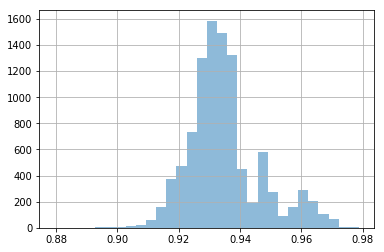

In [368]:
_, _, stats_concepts_pos = PSM.mine_obj_intersections(10000, 10, 'neg')
stats_concepts_pos['neg_confidence'].hist(alpha = 0.5, bins = 30)

In [369]:
%%time
subs_alpha_dict = {
    2:np.linspace(0.5,1,12),
    3:np.linspace(0.8,1,8),
    5:np.linspace(0.85,1,10),
    10:np.linspace(0.88,0.98,11)
}

MyParamGrid = []
for subs_size in subs_alpha_dict:
    for alpha in subs_alpha_dict[subs_size]:
        params = {
            'subs_size': subs_size,
            'alpha': alpha,
            'hypo_type': 'neg',
            'N_hypo_need': 2000,
            'N_iterations': 400000,
            'batch_size': 10000,
        }
        save_path = os.path.join(DATA_FOLDER, 
                                 'Hypotheses',
                                 params['hypo_type'] + '_' + 
                                 str(params['subs_size']) + '_' + 
                                 str(round(params['alpha'], 4)))
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        params['save_path'] = save_path
        MyParamGrid.append(params)

import multiprocessing

pool = multiprocessing.Pool(processes=50) #use all available cores, otherwise specify the number you want as an argument
for args in MyParamGrid:
    pool.apply_async(PSM.mine_hypotheses, args=(args['alpha'],
                                                args['hypo_type'],
                                                args['subs_size'],
                                                args['N_hypo_need'],
                                                args['N_iterations'],
                                                args['batch_size'],
                                                args['save_path'],
                                               ))
pool.close()
pool.join()

Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9315


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/sit

N_mined_hypos of type neg 9915


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/i

N_mined_hypos of type neg 2038


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 30
Mining 10000 intersections
N_mined_hypos of type neg 9913


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9992


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 1150
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 5986


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 657
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9630
N_mined_hypos of type neg 9959


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9905


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 97
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/i

N_mined_hypos of type neg 10
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9983
N_mined_hypos of type neg 1515
Mining 10000 intersections
N_mined_hypos of type neg 9965


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9753
N_mined_hypos of type neg 10000


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 6430


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9223


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9904
N_mined_hypos of type neg 1184
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 5422
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 9998
N_mined_hypos of type neg 8986
N_mined_hypos of type neg 9942


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9975
N_mined_hypos of type neg 9406


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 6601
N_mined_hypos of type neg 9683


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9965


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 3669
N_mined_hypos of type neg 9973


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9817


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 8151
N_mined_hypos of type neg 9981


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 2302
N_mined_hypos of type neg 8452
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 79
Mining 10000 intersections
N_mined_hypos of type neg 1274
N_mined_hypos of type neg 2296
Mining 10000 intersections
N_mined_hypos of type neg 182
Mining 10000 intersections
N_mined_hypos of type neg 2974
N_mined_hypos of type neg 18
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 2280
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 119
Mining 10000 intersections
N_mined_hypos of type neg 1903
Mining 10000 intersections
N_mined_hypos of type neg 275
Mining 10000 intersections
N_mined_hypos of type neg 30
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 159
Mining 10000 intersections
N_mined_hypos of type neg 2551
N_mined_hypos of type neg 3

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 142
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 631
Mining 10000 intersections
N_mined_hypos of type neg 1488
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 156
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 670
Mining 10000 intersections
N_mined_hypos of type neg 1602
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 169
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 708
Mining 10000 intersections
N_mined_hypos of type neg 1699
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 175
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 749
Mining 10000 intersections
N_mined_hypos of type neg 1796
Mining 1000

### PatternStructuresClassifier

In [27]:
class PatternStructuresClassifier():
    """
    Classifier turns hypotheses given test objects into classifiers
    """
    def __init__(self, data_pos, data_neg, feature_list):
        """
        :param data_pos: Pandas.DataFrame with objects from class 1
        :param data_neg: Pandas.DataFrame with objects from class 0
        :param feature_list: list of column names used as features
        """
        self.data_pos = data_pos[feature_list]
        self.data_neg = data_neg[feature_list]
        self.X_pos_expanded = self.data_pos.values[None,:,:]
        self.X_neg_expanded = self.data_neg.values[None,:,:]
        self.feature_list = feature_list
        self.is_nan_X_pos_expanded = np.isnan(self.X_pos_expanded)
        self.is_nan_X_neg_expanded = np.isnan(self.X_neg_expanded)
        
    def classify_test_objects(self, X_test, hypotheses_min, hypotheses_max, alpha, 
                              save_scores_file_path=None, print_when_over=False):
        """
        :X_test: Pandas.DataFrame with objects from class 1
        :hypotheses_min: min_bound of hypotheses of shape (n_hypos, n_feat)
        :hypotheses_max: max_bound of hypotheses of shape (n_hypos, n_feat)
        :alpha: list of column names used as features
        :save_scores_file_path: path to FILE with scores for given test objects
        :print_when_over: print a message when completed (useful for parallel computing)
        """
        SCORE_RES = []
        for i in range(X_test.shape[0]):
            test_obj = X_test[[i],:]
#             test_obj = X_test[:,:]

            classifier_min = np.nanmin([np.repeat(test_obj, hypotheses_min.shape[0], axis=0), hypotheses_min], axis=0)[:,None,:]
            classifier_max = np.nanmax([np.repeat(test_obj, hypotheses_max.shape[0], axis=0), hypotheses_max], axis=0)[:,None,:]

            num_POS_objs_in_clfs = ((((classifier_min <= self.X_pos_expanded) | np.isnan(classifier_min)) & 
                                    ((classifier_max >= self.X_pos_expanded) | np.isnan(classifier_max))) | 
                                    self.is_nan_X_pos_expanded).all(axis=-1).sum(axis=-1)
            num_NEG_objs_in_clfs = ((((classifier_min <= self.X_neg_expanded) | np.isnan(classifier_min)) & 
                                    ((classifier_max >= self.X_neg_expanded) | np.isnan(classifier_max))) | 
                                    self.is_nan_X_neg_expanded).all(axis=-1).sum(axis=-1)
            NO_OBJ_IN_CLF = ((num_POS_objs_in_clfs == 0) & (num_NEG_objs_in_clfs == 0)).sum()
            print(NO_OBJ_IN_CLF)
            num_POS_objs_in_clfs[(num_POS_objs_in_clfs == 0) & (num_NEG_objs_in_clfs == 0)] = 1
            POS_confinedce = num_POS_objs_in_clfs / (num_NEG_objs_in_clfs + num_POS_objs_in_clfs)
#             POS_confinedce = POS_confinedce[POS_confinedce == POS_confinedce]
            NEG_confinedce = 1 - POS_confinedce

            POS_alpha_weak_sum = (POS_confinedce >= alpha).sum(axis=-1)
            NEG_alpha_weak_sum = (NEG_confinedce >= alpha).sum(axis=-1)
            POS_alpha_weak_conf_sum = POS_confinedce[POS_confinedce >= alpha].sum(axis=-1)
            NEG_alpha_weak_conf_sum = NEG_confinedce[NEG_confinedce >= alpha].sum(axis=-1)
            
            POS_alpha_weak_mean = (POS_confinedce >= alpha).mean(axis=-1)
            NEG_alpha_weak_mean = (NEG_confinedce >= alpha).mean(axis=-1)
            POS_alpha_weak_conf_mean_alpha = POS_confinedce[POS_confinedce >= alpha].mean(axis=-1)
            NEG_alpha_weak_conf_mean_alpha = NEG_confinedce[NEG_confinedce >= alpha].mean(axis=-1)
            POS_alpha_weak_conf_mean_all = (POS_confinedce*(POS_confinedce >= alpha)).mean(axis=-1)
            NEG_alpha_weak_conf_mean_all = (NEG_confinedce*(NEG_confinedce >= alpha)).mean(axis=-1)


            scores_dict = {
                'num_POS_objs_sum' : num_POS_objs_in_clfs.sum(axis=-1),
                'num_NEG_objs_sum' : num_NEG_objs_in_clfs.sum(axis=-1),
                'POS_confinedce_sum' : POS_confinedce.sum(axis=-1),
                'NEG_confinedce_sum' : NEG_confinedce.sum(axis=-1),
                'num_POS_alpha_weak_sum' : POS_alpha_weak_sum,
                'num_NEG_alpha_weak_sum' : NEG_alpha_weak_sum,
                'POS_alpha_weak_conf_sum' : POS_alpha_weak_conf_sum,
                'NEG_alpha_weak_conf_sum' : NEG_alpha_weak_conf_sum,
                
                'num_POS_objs_mean' : num_POS_objs_in_clfs.mean(axis=-1),
                'num_NEG_objs_mean' : num_NEG_objs_in_clfs.mean(axis=-1),
                'POS_confinedce_mean' : POS_confinedce.mean(axis=-1),
                'NEG_confinedce_mean' : NEG_confinedce.mean(axis=-1),
                'num_POS_alpha_weak_mean' : POS_alpha_weak_mean,
                'num_NEG_alpha_weak_mean' : NEG_alpha_weak_mean,
                'POS_alpha_weak_conf_mean_alpha' : POS_alpha_weak_conf_mean_alpha,
                'NEG_alpha_weak_conf_mean_alpha' : NEG_alpha_weak_conf_mean_alpha,
                'POS_alpha_weak_conf_mean_all' : POS_alpha_weak_conf_mean_all,
                'NEG_alpha_weak_conf_mean_all' : NEG_alpha_weak_conf_mean_all,
                
#                 'num_POS2NEG_clf' : np.divide(num_POS_objs_in_clfs.astype(np.float32), 
#                                        num_NEG_objs_in_clfs.astype(np.float32), 
#                                        out=np.ones_like(num_POS_objs_in_clfs.astype(np.float32))*self.data_pos.shape[0],
#                                        where=num_NEG_objs_in_clfs.astype(np.float32)!=0).sum(axis=-1),
            }
            SCORE_RES.append(scores_dict)
            
        df_test_scores = pd.DataFrame(SCORE_RES)
        if save_scores_file_path:
            df_test_scores.to_csv(save_scores_file_path)
        
        if print_when_over:
            print(hypo_source_path, " is OVER now!!!")
        return df_test_scores

In [28]:
# features = ['term', 'int_rate', 'grade', 'emp_length', 'annual_inc', 'pymnt_plan',
#        'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
#        'revol_bal', 'revol_util', 'initial_list_status', 'out_prncp_inv',
#        'total_rec_late_fee', 'collection_recovery_fee', 'last_pymnt_amnt',
#        'collections_12_mths_ex_med', 'mths_since_last_major_derog',
#        'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
#        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
#        '13', '14', '15', '16', '17', '18']
features = ['term', 'grade', 'emp_length', 'annual_inc', 'pymnt_plan',
       'out_prncp_inv', 'delinq_2yrs', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15']

In [29]:
PS_clf = PatternStructuresClassifier(df_train_pos, df_train_neg, features)

#### Parallel through all combinations of Hyperparams

In [30]:
N_HYPO_MAX = 2000
N_PROC = 50

In [449]:
def is_non_zero_file(fpath):
    return True if os.path.isfile(fpath) and os.path.getsize(fpath) > 0 else False

listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
# listdir.remove('.ipynb_checkpoints')
np.random.shuffle(listdir)

MyParamGrid = []
for hypo_source_dir in listdir:
    _, _, alpha = hypo_source_dir.split('_')
    alpha = float(alpha)
    
    hypo_source_path = os.path.join(DATA_FOLDER,'Hypotheses', hypo_source_dir)
    hypo_path_min = os.path.join(hypo_source_path, 'hypotheses_min.csv')
    hypo_path_max = os.path.join(hypo_source_path, 'hypotheses_max.csv')

    if is_non_zero_file(hypo_path_min):
        hypotheses_min = pd.read_csv(hypo_path_min, header=None).values[:N_HYPO_MAX]
        hypotheses_max = pd.read_csv(hypo_path_max, header=None).values[:N_HYPO_MAX]

        args = {
            'X_test':X_test,
            'hypotheses_min':hypotheses_min,
            'hypotheses_max':hypotheses_max,
            'alpha':alpha,
            'save_scores_file_path':os.path.join(hypo_source_path, 'df_test_scores.csv'),
            'print_when_over':True
        }

        MyParamGrid.append(args)
len(MyParamGrid)

72

#### Parallel through X_test (one set of params)

In [35]:
N_HYPO_MAX = 2000
N_PROC = 50
batch_size = int(np.ceil(X_test.shape[0]/N_PROC))
batch_size

100

In [36]:
def is_non_zero_file(fpath):
    return True if os.path.isfile(fpath) and os.path.getsize(fpath) > 0 else False

listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
# listdir.remove('.ipynb_checkpoints')
np.random.shuffle(listdir)

In [39]:
hypo_source_dir = 'pos_5_0.3'
_, _, alpha = hypo_source_dir.split('_')
alpha = float(alpha)
hypo_source_path = os.path.join(DATA_FOLDER,'Hypotheses', hypo_source_dir)
hypo_path_min = os.path.join(hypo_source_path, 'hypotheses_min.csv')
hypo_path_max = os.path.join(hypo_source_path, 'hypotheses_max.csv')

print("Any hypotheses in there? ", is_non_zero_file(hypo_path_min))

MyParamGrid = []
if is_non_zero_file(hypo_path_min):
    hypotheses_min = pd.read_csv(hypo_path_min, header=None).values[:N_HYPO_MAX]
    hypotheses_max = pd.read_csv(hypo_path_max, header=None).values[:N_HYPO_MAX]
    hypotheses_min.shape, hypotheses_max.shape
    for i in range(N_PROC):
    # for test_obj in X_test[:90]:
        args = {
    #         'X_test':test_obj[None,:],
            'X_test':X_test[batch_size*i:batch_size*(i+1)],
            'hypotheses_min':hypotheses_min,
            'hypotheses_max':hypotheses_max,
            'alpha':alpha,
            'save_scores_file_path':None,
            'print_when_over':False
        }
        MyParamGrid.append(args)

Any hypotheses in there?  True


((599, 23), (599, 23))

In [37]:
# N_HYPO_MAX = 20000
# def is_non_zero_file(fpath):
#     return True if os.path.isfile(fpath) and os.path.getsize(fpath) > 0 else False

# listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
# # listdir.remove('.ipynb_checkpoints')
# np.random.shuffle(listdir)

# hypo_source_dir = 'pos_4_0.75'
# _, _, alpha = hypo_source_dir.split('_')
# alpha = float(alpha)
# hypo_source_path = os.path.join(DATA_FOLDER,'Hypotheses', hypo_source_dir)
# hypo_path_min = os.path.join(hypo_source_path, 'hypotheses_min.csv')
# hypo_path_max = os.path.join(hypo_source_path, 'hypotheses_max.csv')

# hypotheses_min = pd.read_csv(hypo_path_min, header=None).values[:N_HYPO_MAX]
# hypotheses_max = pd.read_csv(hypo_path_max, header=None).values[:N_HYPO_MAX]

In [97]:
# param_grid = {
#     'subs_size': 4,
#     'alpha': 0.75, 
#     'hypo_type' : 'pos',
#     'N_hypo_need' : 10000,
#     'N_iterations' : 100000,
#     'batch_size' : 10000,
# }

# hypotheses_min, hypotheses_max = PSM.mine_hypotheses(**param_grid)

In [36]:
# i = 20
# self = PS_clf
# test_obj = X_test[[i],:]
# #             test_obj = X_test[:,:]
# test_obj
# classifier_min = np.nanmin([np.repeat(test_obj, hypotheses_min.shape[0], axis=0), hypotheses_min], axis=0)[:,None,:]
# classifier_max = np.nanmax([np.repeat(test_obj, hypotheses_max.shape[0], axis=0), hypotheses_max], axis=0)[:,None,:]

# hypotheses_min_reshape = hypotheses_min[:,None,:]
# hypotheses_max_reshape = hypotheses_max[:,None,:]
# hypotheses_min.shape
# classifier_min.shape

# num_POS_objs_in_clfs = ((((hypotheses_min_reshape <= self.X_pos_expanded) | np.isnan(hypotheses_min_reshape)) & 
#                         ((hypotheses_max_reshape >= self.X_pos_expanded) | np.isnan(hypotheses_max_reshape))) | 
#                         self.is_nan_X_pos_expanded).all(axis=-1).sum(axis=-1)
# num_NEG_objs_in_clfs = ((((hypotheses_min_reshape <= self.X_neg_expanded) | np.isnan(hypotheses_max_reshape)) & 
#                         ((hypotheses_min_reshape >= self.X_neg_expanded) | np.isnan(hypotheses_max_reshape))) | 
#                         self.is_nan_X_neg_expanded).all(axis=-1).sum(axis=-1)
# NO_OBJ_IN_CLF = ((num_POS_objs_in_clfs == 0) & (num_NEG_objs_in_clfs == 0)).sum()
# NO_OBJ_IN_CLF


# num_POS_objs_in_clfs = ((((classifier_min <= self.X_pos_expanded) | np.isnan(classifier_min)) & 
#                         ((classifier_max >= self.X_pos_expanded) | np.isnan(classifier_max))) | 
#                         self.is_nan_X_pos_expanded).all(axis=-1).sum(axis=-1)
# num_NEG_objs_in_clfs = ((((classifier_min <= self.X_neg_expanded) | np.isnan(classifier_min)) & 
#                         ((classifier_max >= self.X_neg_expanded) | np.isnan(classifier_max))) | 
#                         self.is_nan_X_neg_expanded).all(axis=-1).sum(axis=-1)
# NO_OBJ_IN_CLF = ((num_POS_objs_in_clfs == 0) & (num_NEG_objs_in_clfs == 0)).sum()
# NO_OBJ_IN_CLF

# num_POS_objs_in_clfs[(num_POS_objs_in_clfs == 0) & (num_NEG_objs_in_clfs == 0)] = 1
# POS_confinedce = num_POS_objs_in_clfs / (num_NEG_objs_in_clfs + num_POS_objs_in_clfs)
# #             POS_confinedce = POS_confinedce[POS_confinedce == POS_confinedce]
# NEG_confinedce = 1 - POS_confinedce

# POS_alpha_weak_sum = (POS_confinedce >= alpha).sum(axis=-1)
# NEG_alpha_weak_sum = (NEG_confinedce >= alpha).sum(axis=-1)
# POS_alpha_weak_conf_sum = POS_confinedce[POS_confinedce >= alpha].sum(axis=-1)
# NEG_alpha_weak_conf_sum = NEG_confinedce[NEG_confinedce >= alpha].sum(axis=-1)

# POS_alpha_weak_mean = (POS_confinedce >= alpha).mean(axis=-1)
# NEG_alpha_weak_mean = (NEG_confinedce >= alpha).mean(axis=-1)
# POS_alpha_weak_conf_mean_alpha = POS_confinedce[POS_confinedce >= alpha].mean(axis=-1)
# NEG_alpha_weak_conf_mean_alpha = NEG_confinedce[NEG_confinedce >= alpha].mean(axis=-1)
# POS_alpha_weak_conf_mean_all = (POS_confinedce*(POS_confinedce >= alpha)).mean(axis=-1)
# NEG_alpha_weak_conf_mean_all = (NEG_confinedce*(NEG_confinedce >= alpha)).mean(axis=-1)



In [35]:
# classify_test_objects(PS_clf, args['X_test'],args['hypotheses_min'],
#                                                                args['hypotheses_max'],
#                                                                args['alpha'],
#                                                                args['save_scores_file_path'],
#                                                                args['print_when_over']
#                                                               )

#### Run parallel

In [40]:
%%time
import multiprocessing
pool = multiprocessing.Pool(processes=50) #use all available cores, otherwise specify the number you want as an argument

results = []
for args in MyParamGrid:
#     print(args)
    res = pool.apply_async(PS_clf.classify_test_objects, args=(args['X_test'],
                                                               args['hypotheses_min'],
                                                               args['hypotheses_max'],
                                                               args['alpha'],
                                                               args['save_scores_file_path'],
                                                               args['print_when_over']
                                                              ))
    results.append(res)
    
pool.close()
pool.join()#### Run parallel

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipyk

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipyk

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-package

0


/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-pac

0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/s

0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-

0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


#### Collect results (one set of params)

In [42]:
df_results = pd.concat([res.get() for res in results])
df_results.shape

(5000, 18)

In [67]:
df_results.to_csv(os.path.join(hypo_source_path, 'df_test_scores.csv'))

#### Run all listdir but parallel throug X_test objects

In [43]:
import multiprocessing

In [ ]:
%%time
N_HYPO_MAX = 1000
N_PROC = 50
batch_size = int(np.ceil(X_test.shape[0]/N_PROC))
batch_size

def is_non_zero_file(fpath):
    return True if os.path.isfile(fpath) and os.path.getsize(fpath) > 0 else False

listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
# listdir.remove('.ipynb_checkpoints')
np.random.shuffle(listdir)

listdir_FINAL = []
for hypo_source_dir in listdir:
    hypo_source_path = os.path.join(DATA_FOLDER,'Hypotheses', hypo_source_dir)
    if 'df_test_scores.csv' not in os.listdir(hypo_source_path):
        listdir_FINAL.append(hypo_source_dir)

for hypo_source_dir in listdir_FINAL:
    _, _, alpha = hypo_source_dir.split('_')
    alpha = float(alpha)
    hypo_source_path = os.path.join(DATA_FOLDER,'Hypotheses', hypo_source_dir)
    hypo_path_min = os.path.join(hypo_source_path, 'hypotheses_min.csv')
    hypo_path_max = os.path.join(hypo_source_path, 'hypotheses_max.csv')

    print("Any hypotheses in there? ", is_non_zero_file(hypo_path_min))

    MyParamGrid = []
    if is_non_zero_file(hypo_path_min):
        hypotheses_min = pd.read_csv(hypo_path_min, header=None).values[:N_HYPO_MAX]
        hypotheses_max = pd.read_csv(hypo_path_max, header=None).values[:N_HYPO_MAX]
        hypotheses_min.shape, hypotheses_max.shape
        for i in range(N_PROC):
        # for test_obj in X_test[:90]:
            args = {
        #         'X_test':test_obj[None,:],
                'X_test':X_test[batch_size*i:batch_size*(i+1)],
                'hypotheses_min':hypotheses_min,
                'hypotheses_max':hypotheses_max,
                'alpha':alpha,
                'save_scores_file_path':None,
                'print_when_over':False
            } 
            MyParamGrid.append(args)

        pool = multiprocessing.Pool(processes=N_PROC) #use all available cores, otherwise specify the number you want as an argument
        results = []
        for args in MyParamGrid:
            res = pool.apply_async(PS_clf.classify_test_objects, args=(args['X_test'],
                                                                       args['hypotheses_min'],
                                                                       args['hypotheses_max'],
                                                                       args['alpha'],
                                                                       args['save_scores_file_path'],
                                                                       args['print_when_over']
                                                                      ))
            results.append(res)

        pool.close()
        pool.join()#### Run parallel
        df_results = pd.concat([res.get() for res in results])
        df_results.shape
        df_results.to_csv(os.path.join(hypo_source_path, 'df_test_scores.csv'))

Any hypotheses in there?  True


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykern

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykern

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: Runti

0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-

0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.


0


/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.


0


/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.


0


/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


#### Collectt all df_scores

In [114]:
listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
# listdir.remove('.ipynb_checkpoints')
np.random.shuffle(listdir)

df_test_scores_dict = {'pos':{},'neg':{}}
metrics_LIST = []
for hypo_source_dir in listdir:
    df_test_scores_path = os.path.join(DATA_FOLDER,'Hypotheses',hypo_source_dir,'df_test_scores.csv')
    try:
        df_test_scores = pd.read_csv(df_test_scores_path, index_col=0)
        df_test_scores = df_test_scores.fillna(0)
        clf_type, _, _ = hypo_source_dir.split('_')
        df_test_scores_dict[clf_type][hypo_source_dir] = {
            'df_test_scores':df_test_scores,
        }
        metrics_dict_temp = {col:2*metrics.roc_auc_score(y_test, df_test_scores[col]) - 1 for col in df_test_scores.columns}
        metrics_dict_temp['hypo_params'] = hypo_source_dir
        metrics_dict_temp['hypo_type'] = clf_type
        metrics_LIST.append(metrics_dict_temp)
    except FileNotFoundError: 
        print("No hypotheses were mined in '" + df_test_scores_path + "'")

In [121]:
df_metrics_all = pd.DataFrame(metrics_LIST).query("hypo_type == 'pos'")
df_metrics_all.max()
df_metrics_all.min()

NEG_alpha_weak_conf_mean_all              0
NEG_alpha_weak_conf_mean_alpha            0
NEG_alpha_weak_conf_sum                   0
NEG_confinedce_mean               -0.382362
NEG_confinedce_sum                -0.382362
POS_alpha_weak_conf_mean_all       0.450176
POS_alpha_weak_conf_mean_alpha     0.450176
POS_alpha_weak_conf_sum            0.450176
POS_confinedce_mean                0.455148
POS_confinedce_sum                 0.455148
hypo_params                       pos_5_0.3
hypo_type                               pos
num_NEG_alpha_weak_mean                   0
num_NEG_alpha_weak_sum                    0
num_NEG_objs_mean                 -0.214034
num_NEG_objs_sum                  -0.214034
num_POS_alpha_weak_mean            0.448482
num_POS_alpha_weak_sum             0.448482
num_POS_objs_mean                 0.0437414
num_POS_objs_sum                  0.0437414
dtype: object

NEG_alpha_weak_conf_mean_all         -0.46835
NEG_alpha_weak_conf_mean_alpha       -0.54948
NEG_alpha_weak_conf_sum              -0.46835
NEG_confinedce_mean                 -0.455148
NEG_confinedce_sum                  -0.455148
POS_alpha_weak_conf_mean_all         0.236477
POS_alpha_weak_conf_mean_alpha     0.00961127
POS_alpha_weak_conf_sum              0.236477
POS_confinedce_mean                  0.382362
POS_confinedce_sum                   0.382362
hypo_params                       pos_10_0.05
hypo_type                                 pos
num_NEG_alpha_weak_mean             -0.465558
num_NEG_alpha_weak_sum              -0.465558
num_NEG_objs_mean                   -0.388668
num_NEG_objs_sum                    -0.388668
num_POS_alpha_weak_mean                     0
num_POS_alpha_weak_sum                      0
num_POS_objs_mean                   -0.330914
num_POS_objs_sum                    -0.330914
dtype: object

In [122]:
df_metrics_all = pd.DataFrame(metrics_LIST).query("hypo_type == 'neg'")
df_metrics_all.max()
df_metrics_all.min()

NEG_alpha_weak_conf_mean_all       -0.0303481
NEG_alpha_weak_conf_mean_alpha     -0.0303333
NEG_alpha_weak_conf_sum            -0.0303481
NEG_confinedce_mean                 -0.487641
NEG_confinedce_sum                  -0.487641
POS_alpha_weak_conf_mean_all        0.0048694
POS_alpha_weak_conf_mean_alpha      0.0048694
POS_alpha_weak_conf_sum             0.0048694
POS_confinedce_mean                  0.534093
POS_confinedce_sum                   0.534093
hypo_params                         neg_5_1.0
hypo_type                                 neg
num_NEG_alpha_weak_mean           0.000215008
num_NEG_alpha_weak_sum            0.000215008
num_NEG_objs_mean                    0.498335
num_NEG_objs_sum                     0.498335
num_POS_alpha_weak_mean            0.00487063
num_POS_alpha_weak_sum             0.00487063
num_POS_objs_mean                    0.508897
num_POS_objs_sum                     0.508897
dtype: object

NEG_alpha_weak_conf_mean_all        -0.522419
NEG_alpha_weak_conf_mean_alpha      -0.537696
NEG_alpha_weak_conf_sum             -0.522419
NEG_confinedce_mean                 -0.534093
NEG_confinedce_sum                  -0.534093
POS_alpha_weak_conf_mean_all     -0.000215008
POS_alpha_weak_conf_mean_alpha   -0.000215008
POS_alpha_weak_conf_sum          -0.000215008
POS_confinedce_mean                  0.487641
POS_confinedce_sum                   0.487641
hypo_params                       neg_10_0.88
hypo_type                                 neg
num_NEG_alpha_weak_mean             -0.521981
num_NEG_alpha_weak_sum              -0.521981
num_NEG_objs_mean                   0.0941942
num_NEG_objs_sum                    0.0941942
num_POS_alpha_weak_mean          -0.000215008
num_POS_alpha_weak_sum           -0.000215008
num_POS_objs_mean                    0.371171
num_POS_objs_sum                     0.371171
dtype: object

In [123]:
pos_field = 'POS_confinedce_sum'
df_sorted_by_metric = df_metrics_all.sort_values(pos_field)[['hypo_params', pos_field]]
df_sorted_by_metric.head()
df_sorted_by_metric.tail()

,hypo_params,POS_confinedce_sum
22,neg_10_0.89,0.487641
67,neg_10_0.92,0.487934
0,neg_10_0.91,0.488363
66,neg_10_0.88,0.488592
21,neg_10_0.9,0.488592


,hypo_params,POS_confinedce_sum
55,neg_3_0.9714,0.526191
27,neg_3_0.9429,0.526799
25,neg_5_0.9667,0.526862
15,neg_5_0.95,0.532125
29,neg_10_0.95,0.534093


In [84]:
neg_field = 'NEG_alpha_weak_conf_sum'
df_sorted_by_metric = df_metrics_all.sort_values(neg_field)[['hypo_params', neg_field]]
df_sorted_by_metric.head()
df_sorted_by_metric.tail()

,hypo_params,NEG_alpha_weak_conf_sum
29,neg_3_0.57,-0.686846
965,neg_3_0.69,-0.686570
361,neg_3_0.67,-0.685598
279,neg_3_0.63,-0.685133
1359,neg_3_0.59,-0.685117


,hypo_params,NEG_alpha_weak_conf_sum
377,pos_10_0.84,0.0
801,pos_9_0.86,0.0
1349,pos_6_0.92,0.0
1307,pos_6_0.96,0.0
1230,pos_3_0.98,0.0


In [85]:
neg = 'neg_3_0.83'
pos = 'pos_2_0.12'
final_score = df_test_scores_dict['pos'][pos]['df_test_scores'][pos_field] / \
            df_test_scores_dict['neg'][neg]['df_test_scores'][neg_field]
2*metrics.roc_auc_score(y_test, final_score) - 1

0.6681457540643376

In [86]:
neg = 'neg_3_0.57'
pos = 'neg_3_0.64'
final_score = df_test_scores_dict['neg'][pos]['df_test_scores'][pos_field] / \
            df_test_scores_dict['neg'][neg]['df_test_scores'][neg_field]
2*metrics.roc_auc_score(y_test, final_score) - 1

0.6822358180560362

In [41]:
# df_pos_clf_scores.head().columns

In [42]:
# df_pos_clf_scores['NEG_alpha_weak_conf_sum'] / df_pos_clf_scores['NEG_alpha_weak_conf_mean_all'] 
# , 'NEG_alpha_weak_conf_sum'

In [27]:
df_pos_clf_scores = df_test_scores_dict['pos']['pos_3_0.8']['df_test_scores']
df_neg_clf_scores = df_test_scores_dict['neg']['neg_10_0.75']['df_test_scores']
fields_pos = ['POS_alpha_weak_conf_mean_all', 
              'POS_alpha_weak_conf_mean_alpha',
              'POS_alpha_weak_conf_sum', 
              'POS_confinedce_mean',
              'POS_confinedce_sum',
              'num_POS_alpha_weak_mean',
              'num_POS_alpha_weak_sum',
              'num_POS_objs_mean',
              'num_POS_objs_sum']
fields_neg = ['NEG_alpha_weak_conf_mean_all', 
              'NEG_alpha_weak_conf_mean_alpha',
              'NEG_alpha_weak_conf_sum', 
              'NEG_confinedce_mean',
              'NEG_confinedce_sum',       
              'num_NEG_alpha_weak_mean',
              'num_NEG_alpha_weak_sum',
              'num_NEG_objs_mean',
              'num_NEG_objs_sum']
         
def aggregate_two_clf_scores(df_clf_scores_1, df_clf_scores_2, 
                             clf_type_1, clf_type_2,
                             fileds_pos, fields_neg):
    fields_1 = fileds_pos if clf_type_1 == 'pos' else fields_neg
    fields_2 = fileds_pos if clf_type_1 == 'pos' else fields_neg
    df_clf_agg = df_clf_scores_1[fields_1] + df_clf_scores_2[fields_2]
    

In [76]:
df_scores = df_test_scores_dict['pos']['pos_3_0.8']['df_test_scores']
df_scores.isnull().sum()
df_scores = df_scores.fillna(0)

for col in df_scores.columns:
    col, 2*metrics.roc_auc_score(y_test, df_scores[col]) - 1

NEG_alpha_weak_conf_mean_all      0
NEG_alpha_weak_conf_mean_alpha    1
NEG_alpha_weak_conf_sum           0
NEG_confinedce_mean               0
NEG_confinedce_sum                0
POS_alpha_weak_conf_mean_all      0
POS_alpha_weak_conf_mean_alpha    3
POS_alpha_weak_conf_sum           0
POS_confinedce_mean               0
POS_confinedce_sum                0
num_NEG_alpha_weak_mean           0
num_NEG_alpha_weak_sum            0
num_NEG_objs_mean                 0
num_NEG_objs_sum                  0
num_POS_alpha_weak_mean           0
num_POS_alpha_weak_sum            0
num_POS_objs_mean                 0
num_POS_objs_sum                  0
dtype: int64

('NEG_alpha_weak_conf_mean_all', -0.6070780006918021)

('NEG_alpha_weak_conf_mean_alpha', 0.22582475786924938)

('NEG_alpha_weak_conf_sum', -0.6070780006918021)

('NEG_confinedce_mean', -0.635852646143203)

('NEG_confinedce_sum', -0.635852646143203)

('POS_alpha_weak_conf_mean_all', 0.5404650207540644)

('POS_alpha_weak_conf_mean_alpha', -0.4295821082670356)

('POS_alpha_weak_conf_sum', 0.5404650207540644)

('POS_confinedce_mean', 0.6358526461432028)

('POS_confinedce_sum', 0.6358526461432028)

('num_NEG_alpha_weak_mean', -0.6094182376340367)

('num_NEG_alpha_weak_sum', -0.6094182376340367)

('num_NEG_objs_mean', -0.3743027931511588)

('num_NEG_objs_sum', -0.3743027931511588)

('num_POS_alpha_weak_mean', 0.5459534979245935)

('num_POS_alpha_weak_sum', 0.5459534979245935)

('num_POS_objs_mean', 0.035276504669664366)

('num_POS_objs_sum', 0.035276504669664366)

In [116]:
pair_of_cols = [
    ('num_POS_objs_sum', 'num_NEG_objs_sum'),
    ('POS_confinedce_sum', 'NEG_confinedce_sum'),
    ('num_POS_alpha_weak_sum', 'num_NEG_alpha_weak_sum'),
    ('POS_alpha_weak_conf_sum', 'NEG_alpha_weak_conf_sum'),
    ('num_POS_objs_mean', 'num_NEG_objs_mean'),
    ('POS_confinedce_mean', 'NEG_confinedce_mean'),
    ('num_POS_alpha_weak_mean', 'num_NEG_alpha_weak_mean'),
    ('POS_alpha_weak_conf_mean_alpha', 'NEG_alpha_weak_conf_mean_alpha'),
    ('POS_alpha_weak_conf_mean_all', 'NEG_alpha_weak_conf_mean_all'),
]

In [118]:
df_scores_1 = df_test_scores_dict['pos']['pos_4_0.6']['df_test_scores']
df_scores_1 = df_scores_1.fillna(0)

df_scores_2 = df_test_scores_dict['neg']['neg_6_0.76']['df_test_scores']
df_scores_2 = df_scores_2.fillna(0)

for col_1, col_2 in pair_of_cols:
    col_1, col_2, 2*metrics.roc_auc_score(y_test, df_scores_1[col_1] - df_scores_2[col_2]) - 1
    col_1, col_2, 2*metrics.roc_auc_score(y_test, df_scores_1[col_1] / (df_scores_1[col_1] + df_scores_2[col_2]) ) - 1
    col_1, col_2, 2*metrics.roc_auc_score(y_test, df_scores_1[col_1] / df_scores_2[col_2] ) - 1    

('num_POS_objs_sum', 'num_NEG_objs_sum', -0.4241747016603252)

('num_POS_objs_sum', 'num_NEG_objs_sum', -0.273132134209616)

('num_POS_objs_sum', 'num_NEG_objs_sum', -0.273132134209616)

('POS_confinedce_sum', 'NEG_confinedce_sum', 0.6447487893462469)

('POS_confinedce_sum', 'NEG_confinedce_sum', 0.6341988066413005)

('POS_confinedce_sum', 'NEG_confinedce_sum', 0.6341988066413005)

('num_POS_alpha_weak_sum', 'num_NEG_alpha_weak_sum', 0.6528612504323765)

('num_POS_alpha_weak_sum', 'num_NEG_alpha_weak_sum', 0.635360818056036)

('num_POS_alpha_weak_sum', 'num_NEG_alpha_weak_sum', 0.635360818056036)

('POS_alpha_weak_conf_sum', 'NEG_alpha_weak_conf_sum', 0.6635949930819782)

('POS_alpha_weak_conf_sum', 'NEG_alpha_weak_conf_sum', 0.6346311829816673)

('POS_alpha_weak_conf_sum', 'NEG_alpha_weak_conf_sum', 0.6346311829816673)

('num_POS_objs_mean', 'num_NEG_objs_mean', -0.4241774040124524)

('num_POS_objs_mean', 'num_NEG_objs_mean', -0.273132134209616)

('num_POS_objs_mean', 'num_NEG_objs_mean', -0.273132134209616)

('POS_confinedce_mean', 'NEG_confinedce_mean', 0.6447487893462469)

('POS_confinedce_mean', 'NEG_confinedce_mean', 0.6341988066413005)

('POS_confinedce_mean', 'NEG_confinedce_mean', 0.6341988066413005)

('num_POS_alpha_weak_mean', 'num_NEG_alpha_weak_mean', 0.6529288092355587)

('num_POS_alpha_weak_mean', 'num_NEG_alpha_weak_mean', 0.635360818056036)

('num_POS_alpha_weak_mean', 'num_NEG_alpha_weak_mean', 0.635360818056036)

('POS_alpha_weak_conf_mean_alpha',
 'NEG_alpha_weak_conf_mean_alpha',
 0.39224641127637483)

('POS_alpha_weak_conf_mean_alpha',
 'NEG_alpha_weak_conf_mean_alpha',
 0.3734326357661708)

('POS_alpha_weak_conf_mean_alpha',
 'NEG_alpha_weak_conf_mean_alpha',
 0.3734326357661708)

('POS_alpha_weak_conf_mean_all',
 'NEG_alpha_weak_conf_mean_all',
 0.6635949930819782)

('POS_alpha_weak_conf_mean_all',
 'NEG_alpha_weak_conf_mean_all',
 0.6346311829816673)

('POS_alpha_weak_conf_mean_all',
 'NEG_alpha_weak_conf_mean_all',
 0.6346311829816673)

### Benchmarks

In [49]:
from sklearn import ensemble, model_selection
from sklearn import tree
from sklearn import neighbors

In [50]:
df_train.isnull().sum()

term                0
grade               0
emp_length       1379
annual_inc          0
pymnt_plan          0
out_prncp_inv       0
delinq_2yrs         0
0                   0
1                   0
2                   0
3                   0
4                   0
5                   0
6                   0
7                   0
8                   0
9                   0
10                  0
11                  0
12                  0
13                  0
14                  0
15                  0
dtype: int64

In [51]:
errors = []
growing_rf = ensemble.RandomForestClassifier(n_estimators=1, n_jobs=-1,  
                                    warm_start=True, random_state=1514)
for i in range(20):
    growing_rf.fit(df_train.fillna(df_train.mean()), y_train)
    growing_rf.n_estimators += 10
    metric_val = 2*metrics.roc_auc_score(y_test, growing_rf.predict_proba(df_test.fillna(df_train.mean()))[:,1]) - 1
    errors.append(metric_val)
    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=61, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=91, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=101, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=111, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=131, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=141, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=151, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=161, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=171, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=181, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=191, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

0.4528002789553222

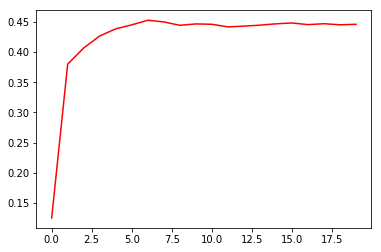

In [52]:
errors = np.array(errors)

final_errors = errors + 0.04
final_errors.max()
plt.plot(final_errors, '-r')

#### RF

In [31]:
np.random.seed(42)

In [32]:
param_grid = {
    'min_samples_leaf': [1,2,4,8,16,32],
    'min_samples_split': [2,4,8,16,32,64],
    'n_estimators': [500],
    'n_jobs': [-1],
    'verbose': [1]
}

In [33]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = ensemble.RandomForestClassifier(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':2*metrics.roc_auc_score(y_train, clf.predict_proba(df_train.fillna(df_train.mean()))[:,1]) - 1,
        'test':2*metrics.roc_auc_score(y_test, clf.predict_proba(df_test.fillna(df_train.mean()))[:,1]) - 1
    })
    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished


In [34]:
pd.DataFrame(METRIC_LIST).max()

test     0.552368
train    0.999764
dtype: float64

#### DT

In [35]:
param_grid = {
    'min_samples_leaf': [1,2,4,8,16,32],
    'min_samples_split': [2,4,8,16,32,64],
}

In [36]:
np.random.seed(42)

In [37]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = tree.DecisionTreeClassifier(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':2*metrics.roc_auc_score(y_train, clf.predict_proba(df_train.fillna(df_train.mean()))[:,1]) - 1,
        'test':2*metrics.roc_auc_score(y_test, clf.predict_proba(df_test.fillna(df_train.mean()))[:,1]) - 1
    })
    

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
pd.DataFrame(METRIC_LIST).max()

test     0.437454
train    0.999874
dtype: float64

#### kNN

In [39]:
np.random.seed(42)

In [40]:
param_grid = {
    'leaf_size': [1,2,4,8,16,32,64],
    'n_neighbors': [1,2,4,8,16,32,64],
    'p': [1,2,3],
    'n_jobs': [-1],
}

In [41]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = neighbors.KNeighborsClassifier(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':2*metrics.roc_auc_score(y_train, clf.predict_proba(df_train.fillna(df_train.mean()))[:,1]) - 1,
        'test':2*metrics.roc_auc_score(y_test, clf.predict_proba(df_test.fillna(df_train.mean()))[:,1]) - 1
    })
    

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

In [42]:
pd.DataFrame(METRIC_LIST).max()

test     0.391312
train    0.977541
dtype: float64

#### xgboost

In [43]:
import xgboost as xgb

In [44]:
np.random.seed(42)

In [45]:
dtrain = xgb.DMatrix(df_train.fillna(df_train.mean()), label=y_train)
dtest = xgb.DMatrix(df_test.fillna(df_train.mean()), label=y_test)

In [46]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'nthread': [-1],
        'eval_metric': ['auc'],
        }

In [47]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    num_round = 100
    bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10)
    METRIC_LIST.append({'best_score':2*bst.best_score - 1})
    

[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.709503	eval-auc:0.727084
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.758863	eval-auc:0.760928
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.759757	eval-auc:0.763931
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.759531	eval-auc:0.7634
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-auc:0.76659	eval-auc:0.771015
[07:32:39] /workspace/src/tree/updater_pru

[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[25]	train-auc:0.785505	eval-auc:0.774644
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[26]	train-auc:0.786015	eval-auc:0.774892
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[27]	train-auc:0.786015	eval-auc:0.774892
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[28]	train-auc:0.786568	eval-auc:0.77567
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[29]	train-auc:0.786568	eval-auc:0.77567
[07:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[30]	train-auc:0.786643	eval-auc:0.775743
[07:32:39] /works

[6]	train-auc:0.767012	eval-auc:0.770583
[07:32:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-auc:0.767331	eval-auc:0.769179
[07:32:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[8]	train-auc:0.768794	eval-auc:0.771492
[07:32:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[9]	train-auc:0.769237	eval-auc:0.770319
[07:32:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[10]	train-auc:0.772158	eval-auc:0.770046
[07:32:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[11]	train-auc:0.772272	eval-auc:0.771516
[07:32:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[12]	train-auc:0.

[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[9]	train-auc:0.775065	eval-auc:0.774163
[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[10]	train-auc:0.776407	eval-auc:0.775761
[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[11]	train-auc:0.776407	eval-auc:0.775761
[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[12]	train-auc:0.77737	eval-auc:0.77581
[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[13]	train-auc:0.777496	eval-auc:0.775847
[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.777496	eval-auc:0.775847
[07:32:41] /worksp

[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[20]	train-auc:0.778993	eval-auc:0.769679
[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[21]	train-auc:0.779798	eval-auc:0.770626
[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[22]	train-auc:0.78018	eval-auc:0.770099
Stopping. Best iteration:
[12]	train-auc:0.774266	eval-auc:0.771011

[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.714802	eval-auc:0.73574
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:32:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-au

[14]	train-auc:0.779501	eval-auc:0.77418
Stopping. Best iteration:
[4]	train-auc:0.774553	eval-auc:0.774971

[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[0]	train-auc:0.711565	eval-auc:0.726769
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[1]	train-auc:0.760522	eval-auc:0.759762
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[2]	train-auc:0.762245	eval-auc:0.761127
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[3]	train-auc:0.764423	eval-auc:0.760246
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes

[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[30]	train-auc:0.795417	eval-auc:0.775435
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[31]	train-auc:0.795903	eval-auc:0.775384
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[32]	train-auc:0.796587	eval-auc:0.773819
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[33]	train-auc:0.796782	eval-auc:0.773948
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[34]	train-auc:0.796775	eval-auc:0.773976
[07:32:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[35]	train-auc:0.798183	eval-auc:0.774539
Stopping.

[07:32:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[2]	train-auc:0.767654	eval-auc:0.765756
[07:32:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-auc:0.768232	eval-auc:0.765231
[07:32:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[4]	train-auc:0.774773	eval-auc:0.772511
[07:32:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[5]	train-auc:0.776178	eval-auc:0.771309
[07:32:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[6]	train-auc:0.775786	eval-auc:0.771678
[07:32:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[7]	train-auc:0.776425	eval-auc:0.770063
[07:32:43] /wo

[7]	train-auc:0.774152	eval-auc:0.766352
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[8]	train-auc:0.774152	eval-auc:0.766352
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 18 pruned nodes, max_depth=1
[9]	train-auc:0.7745	eval-auc:0.765484
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[10]	train-auc:0.775984	eval-auc:0.76372
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 16 pruned nodes, max_depth=3
[11]	train-auc:0.776568	eval-auc:0.763839
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[12]	train-auc:0.778209	eval-auc:0.765929
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[13]	train-a

[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[15]	train-auc:0.788807	eval-auc:0.776244
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[16]	train-auc:0.788807	eval-auc:0.776244
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[17]	train-auc:0.788807	eval-auc:0.776244
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[18]	train-auc:0.788807	eval-auc:0.776244
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[19]	train-auc:0.788807	eval-auc:0.776244
[07:32:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[20]	train-auc:0.788807	eval-auc:0.776244
[07:32:44] 

[07:32:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[25]	train-auc:0.800633	eval-auc:0.766914
[07:32:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nodes, max_depth=5
[26]	train-auc:0.80203	eval-auc:0.765903
Stopping. Best iteration:
[16]	train-auc:0.792859	eval-auc:0.772127

[07:32:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 8 pruned nodes, max_depth=5
[0]	train-auc:0.722379	eval-auc:0.737569
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:32:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 pruned nodes, max_depth=5
[1]	train-auc:0.76894	eval-auc:0.764477
[07:32:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 16 pruned nodes, max_depth=5
[2]	trai

[07:32:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=5
[14]	train-auc:0.800533	eval-auc:0.772164
[07:32:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=5
[15]	train-auc:0.800602	eval-auc:0.772679
[07:32:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 38 pruned nodes, max_depth=5
[16]	train-auc:0.803683	eval-auc:0.773771
[07:32:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 62 pruned nodes, max_depth=0
[17]	train-auc:0.803683	eval-auc:0.773771
[07:32:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 42 pruned nodes, max_depth=4
[18]	train-auc:0.803906	eval-auc:0.773439
[07:32:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[19]	train-auc:0.803906	eval-auc:0.773439
[07:32:

[07:32:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 24 pruned nodes, max_depth=3
[5]	train-auc:0.783137	eval-auc:0.770938
[07:32:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 38 pruned nodes, max_depth=5
[6]	train-auc:0.782999	eval-auc:0.771794
[07:32:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 26 pruned nodes, max_depth=5
[7]	train-auc:0.785141	eval-auc:0.77237
[07:32:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[8]	train-auc:0.785141	eval-auc:0.77237
[07:32:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 32 pruned nodes, max_depth=5
[9]	train-auc:0.785337	eval-auc:0.77152
[07:32:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 32 pruned nodes, max_depth=5
[10]	train-auc:0.786361	eval-auc:0.770978
[07:32:47] /wo

[23]	train-auc:0.798313	eval-auc:0.77481
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 30 pruned nodes, max_depth=4
[24]	train-auc:0.798829	eval-auc:0.775349
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 34 pruned nodes, max_depth=4
[25]	train-auc:0.799088	eval-auc:0.775048
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 32 pruned nodes, max_depth=5
[26]	train-auc:0.801319	eval-auc:0.775632
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 36 pruned nodes, max_depth=5
[27]	train-auc:0.802445	eval-auc:0.773536
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[28]	train-auc:0.802445	eval-auc:0.773536
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[29]	trai

[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 20 pruned nodes, max_depth=1
[8]	train-auc:0.784828	eval-auc:0.771758
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 36 pruned nodes, max_depth=5
[9]	train-auc:0.785064	eval-auc:0.771275
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 32 pruned nodes, max_depth=5
[10]	train-auc:0.785632	eval-auc:0.77093
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 32 pruned nodes, max_depth=5
[11]	train-auc:0.785594	eval-auc:0.771226
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 40 pruned nodes, max_depth=5
[12]	train-auc:0.787685	eval-auc:0.772401
[07:32:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 30 pruned nodes, max_depth=5
[13]	train-auc:0.791119	eval-auc:0.770373
[07:32:4

[07:32:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[27]	train-auc:0.802097	eval-auc:0.776446
[07:32:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[28]	train-auc:0.802097	eval-auc:0.776446
[07:32:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[29]	train-auc:0.802097	eval-auc:0.776446
[07:32:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[30]	train-auc:0.802097	eval-auc:0.776446
[07:32:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[31]	train-auc:0.802097	eval-auc:0.776446
Stopping. Best iteration:
[21]	train-auc:0.800802	eval-auc:0.777122

[07:32:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned no

[3]	train-auc:0.760441	eval-auc:0.760394
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[4]	train-auc:0.764019	eval-auc:0.763645
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[5]	train-auc:0.765938	eval-auc:0.763572
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	train-auc:0.766237	eval-auc:0.764422
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[7]	train-auc:0.76651	eval-auc:0.763538
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[8]	train-auc:0.76651	eval-auc:0.763538
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[9]	train-auc:0.76651

Will train until eval-auc hasn't improved in 10 rounds.
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.747824	eval-auc:0.757814
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[2]	train-auc:0.752936	eval-auc:0.765832
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[3]	train-auc:0.752598	eval-auc:0.765862
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=2
[4]	train-auc:0.765596	eval-auc:0.767954
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[5]	train-auc:0.76892	eval-auc:0.774651
[07:32:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	t

[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[34]	train-auc:0.777566	eval-auc:0.780384
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[35]	train-auc:0.777566	eval-auc:0.780384
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[36]	train-auc:0.777667	eval-auc:0.780282
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[37]	train-auc:0.777287	eval-auc:0.779947
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[38]	train-auc:0.777287	eval-auc:0.779947
Stopping. Best iteration:
[28]	train-auc:0.777566	eval-auc:0.780384

[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned no

[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[44]	train-auc:0.777992	eval-auc:0.777364
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[45]	train-auc:0.777992	eval-auc:0.777364
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[46]	train-auc:0.777992	eval-auc:0.777364
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[47]	train-auc:0.777992	eval-auc:0.777364
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[48]	train-auc:0.777992	eval-auc:0.777364
[07:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[49]	train-auc:0.777992	eval-auc:0.777364
[07:32:51]

[23]	train-auc:0.776109	eval-auc:0.778858
[07:32:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.776109	eval-auc:0.778858
[07:32:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[25]	train-auc:0.776109	eval-auc:0.778858
[07:32:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[26]	train-auc:0.776852	eval-auc:0.780337
[07:32:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[27]	train-auc:0.776852	eval-auc:0.780337
[07:32:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[28]	train-auc:0.776852	eval-auc:0.780337
[07:32:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[29]	train-auc

[22]	train-auc:0.773198	eval-auc:0.773019
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[23]	train-auc:0.773198	eval-auc:0.773019
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.773198	eval-auc:0.773019
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[25]	train-auc:0.773198	eval-auc:0.773019
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[26]	train-auc:0.773671	eval-auc:0.772762
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[27]	train-auc:0.773671	eval-auc:0.772762
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[28]	train-au

[15]	train-auc:0.773607	eval-auc:0.770562
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[16]	train-auc:0.774863	eval-auc:0.771473
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[17]	train-auc:0.774863	eval-auc:0.771473
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[18]	train-auc:0.774863	eval-auc:0.771473
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[19]	train-auc:0.77535	eval-auc:0.771299
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[20]	train-auc:0.77535	eval-auc:0.771299
[07:32:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[21]	train-

Stopping. Best iteration:
[22]	train-auc:0.779979	eval-auc:0.778111

[07:32:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[0]	train-auc:0.703258	eval-auc:0.717998
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:32:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[1]	train-auc:0.762269	eval-auc:0.761886
[07:32:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=4
[2]	train-auc:0.763418	eval-auc:0.765392
[07:32:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=3
[3]	train-auc:0.76771	eval-auc:0.763724
[07:32:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[4]	train

[07:32:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[24]	train-auc:0.777517	eval-auc:0.771941
[07:32:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[25]	train-auc:0.777517	eval-auc:0.771941
[07:32:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[26]	train-auc:0.778296	eval-auc:0.773087
[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[27]	train-auc:0.778296	eval-auc:0.773087
[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[28]	train-auc:0.778296	eval-auc:0.773087
[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[29]	train-auc:0.778296	eval-auc:0.773087
[07:32:55

[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[2]	train-auc:0.763272	eval-auc:0.765356
[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=3
[3]	train-auc:0.767572	eval-auc:0.763751
[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[4]	train-auc:0.771355	eval-auc:0.764257
[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=4
[5]	train-auc:0.774885	eval-auc:0.769603
[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[6]	train-auc:0.774947	eval-auc:0.769847
[07:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[7]	train-auc:0.775444	eval-auc:0.770705
[07:32:55] 

[07:32:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[27]	train-auc:0.777066	eval-auc:0.773266
[07:32:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[28]	train-auc:0.777066	eval-auc:0.773266
[07:32:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[29]	train-auc:0.777066	eval-auc:0.773266
[07:32:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[30]	train-auc:0.777066	eval-auc:0.773266
[07:32:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[31]	train-auc:0.777066	eval-auc:0.773266
[07:32:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[32]	train-auc:0.777066	eval-auc:0.773266
[07:32:56]

[07:32:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[18]	train-auc:0.773831	eval-auc:0.774044
[07:32:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[19]	train-auc:0.774772	eval-auc:0.775188
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[20]	train-auc:0.774772	eval-auc:0.775188
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=3
[21]	train-auc:0.776582	eval-auc:0.77675
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[22]	train-auc:0.776582	eval-auc:0.77675
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[23]	train-auc:0.776582	eval-auc:0.77675
[07:32:57] /w

[7]	train-auc:0.771509	eval-auc:0.762017
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 22 pruned nodes, max_depth=1
[8]	train-auc:0.771509	eval-auc:0.762017
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[9]	train-auc:0.771509	eval-auc:0.762017
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 44 pruned nodes, max_depth=5
[10]	train-auc:0.772631	eval-auc:0.760936
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 36 pruned nodes, max_depth=5
[11]	train-auc:0.774521	eval-auc:0.764477
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 48 pruned nodes, max_depth=2
[12]	train-auc:0.777683	eval-auc:0.77147
[07:32:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 50 pruned nodes, max_depth=5
[13]	train-

[07:32:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=5
[25]	train-auc:0.787875	eval-auc:0.778529
[07:32:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[26]	train-auc:0.788717	eval-auc:0.778032
[07:32:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 48 pruned nodes, max_depth=5
[27]	train-auc:0.789676	eval-auc:0.777223
[07:32:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[28]	train-auc:0.789676	eval-auc:0.777223
[07:32:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[29]	train-auc:0.789676	eval-auc:0.777223
[07:32:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[30]	train-auc:0.789676	eval-auc:0.777223
[07:32:5

[15]	train-auc:0.778265	eval-auc:0.773134
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=4
[16]	train-auc:0.779426	eval-auc:0.774521
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[17]	train-auc:0.779426	eval-auc:0.774521
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 26 pruned nodes, max_depth=5
[18]	train-auc:0.780354	eval-auc:0.774379
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 38 pruned nodes, max_depth=2
[19]	train-auc:0.780727	eval-auc:0.774522
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[20]	train-auc:0.780727	eval-auc:0.774522
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[21]	trai

[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 46 pruned nodes, max_depth=4
[32]	train-auc:0.789602	eval-auc:0.777224
Stopping. Best iteration:
[22]	train-auc:0.787337	eval-auc:0.778803

[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 14 pruned nodes, max_depth=5
[0]	train-auc:0.723335	eval-auc:0.734687
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 20 pruned nodes, max_depth=5
[1]	train-auc:0.767694	eval-auc:0.762867
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=4
[2]	train-auc:0.766454	eval-auc:0.762399
[07:32:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 32 pruned nodes, max_depth=5
[3]	tr

[21]	train-auc:0.778047	eval-auc:0.773354
[07:33:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[22]	train-auc:0.778047	eval-auc:0.773354
[07:33:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[23]	train-auc:0.778047	eval-auc:0.773354
[07:33:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[24]	train-auc:0.778047	eval-auc:0.773354
[07:33:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[25]	train-auc:0.778047	eval-auc:0.773354
[07:33:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 40 pruned nodes, max_depth=5
[26]	train-auc:0.778904	eval-auc:0.773335
[07:33:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[27]	trai

[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 46 pruned nodes, max_depth=5
[13]	train-auc:0.779039	eval-auc:0.771758
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 62 pruned nodes, max_depth=0
[14]	train-auc:0.779039	eval-auc:0.771758
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 42 pruned nodes, max_depth=4
[15]	train-auc:0.779355	eval-auc:0.771301
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[16]	train-auc:0.779355	eval-auc:0.771301
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[17]	train-auc:0.779355	eval-auc:0.771301
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 42 pruned nodes, max_depth=5
[18]	train-auc:0.779494	eval-auc:0.771299
[07:33:0

[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[23]	train-auc:0.784188	eval-auc:0.773903
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[24]	train-auc:0.784188	eval-auc:0.773903
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[25]	train-auc:0.784188	eval-auc:0.773903
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[26]	train-auc:0.784188	eval-auc:0.773903
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[27]	train-auc:0.784188	eval-auc:0.773903
[07:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[28]	train-auc:0.784188	eval-auc:0.773903
[07:33:01]

[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.763947	eval-auc:0.76444
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[15]	train-auc:0.767874	eval-auc:0.771445
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[16]	train-auc:0.768099	eval-auc:0.771558
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[17]	train-auc:0.768099	eval-auc:0.771558
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[18]	train-auc:0.769075	eval-auc:0.771589
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[19]	train-auc:0.769075	eval-auc:0.771589
[07:33:02] /w

[16]	train-auc:0.765478	eval-auc:0.767693
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.765478	eval-auc:0.767693
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.765478	eval-auc:0.767693
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[19]	train-auc:0.766588	eval-auc:0.767513
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[20]	train-auc:0.766588	eval-auc:0.767513
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.766588	eval-auc:0.767513
[07:33:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[22]	train-

[8]	train-auc:0.768514	eval-auc:0.768726
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[9]	train-auc:0.768514	eval-auc:0.768726
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[10]	train-auc:0.769828	eval-auc:0.7679
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[11]	train-auc:0.769828	eval-auc:0.7679
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12]	train-auc:0.769828	eval-auc:0.7679
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.769828	eval-auc:0.7679
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[14]	train-auc:0.769828

[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.763947	eval-auc:0.76444
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[15]	train-auc:0.767874	eval-auc:0.771445
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[16]	train-auc:0.768099	eval-auc:0.771558
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.768099	eval-auc:0.771558
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[18]	train-auc:0.768099	eval-auc:0.771558
[07:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[19]	train-auc:0.768099	eval-auc:0.771558
[07:33:03] 

[18]	train-auc:0.766075	eval-auc:0.767246
[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 22 pruned nodes, max_depth=1
[19]	train-auc:0.767176	eval-auc:0.767329
[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[20]	train-auc:0.767176	eval-auc:0.767329
[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[21]	train-auc:0.767176	eval-auc:0.767329
[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[22]	train-auc:0.767176	eval-auc:0.767329
[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[23]	train-auc:0.767176	eval-auc:0.767329
[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[24]	train

[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[5]	train-auc:0.760832	eval-auc:0.761276
[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[6]	train-auc:0.761985	eval-auc:0.76208
[07:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[7]	train-auc:0.762683	eval-auc:0.761132
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 14 pruned nodes, max_depth=1
[8]	train-auc:0.762683	eval-auc:0.761132
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[9]	train-auc:0.762683	eval-auc:0.761132
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[10]	train-auc:0.764497	eval-auc:0.761729
[07:33:05] /work

[9]	train-auc:0.763444	eval-auc:0.761588
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[10]	train-auc:0.763444	eval-auc:0.761588
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[11]	train-auc:0.763444	eval-auc:0.761588
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[12]	train-auc:0.768205	eval-auc:0.770131
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[13]	train-auc:0.768548	eval-auc:0.770566
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[14]	train-auc:0.768548	eval-auc:0.770566
[07:33:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 24 pruned nodes, max_depth=2
[15]	train-

[07:33:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=3
[0]	train-auc:0.70153	eval-auc:0.718047
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=4
[1]	train-auc:0.758457	eval-auc:0.759849
[07:33:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[2]	train-auc:0.759316	eval-auc:0.760897
[07:33:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[3]	train-auc:0.75868	eval-auc:0.760317
[07:33:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[4]	train-auc:0.762933	eval-auc:0.764317
[07:33:06] /workspace/src/tree/updater_

[07:33:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[27]	train-auc:0.771076	eval-auc:0.771502
[07:33:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[28]	train-auc:0.771076	eval-auc:0.771502
[07:33:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[29]	train-auc:0.771076	eval-auc:0.771502
[07:33:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[30]	train-auc:0.771076	eval-auc:0.771502
[07:33:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[31]	train-auc:0.771076	eval-auc:0.771502
Stopping. Best iteration:
[21]	train-auc:0.771076	eval-auc:0.771502

[07:33:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned n

[07:33:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[13]	train-auc:0.769099	eval-auc:0.768202
[07:33:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[14]	train-auc:0.769099	eval-auc:0.768202
[07:33:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[15]	train-auc:0.769099	eval-auc:0.768202
[07:33:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[16]	train-auc:0.769099	eval-auc:0.768202
Stopping. Best iteration:
[6]	train-auc:0.767647	eval-auc:0.76974

[07:33:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 44 pruned nodes, max_depth=4
[0]	train-auc:0.697834	eval-auc:0.718707
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-a

[07:33:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 52 pruned nodes, max_depth=1
[12]	train-auc:0.769586	eval-auc:0.768838
[07:33:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 54 pruned nodes, max_depth=2
[13]	train-auc:0.770933	eval-auc:0.769895
[07:33:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 62 pruned nodes, max_depth=0
[14]	train-auc:0.770933	eval-auc:0.769895
[07:33:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 44 pruned nodes, max_depth=1
[15]	train-auc:0.773373	eval-auc:0.776522
[07:33:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[16]	train-auc:0.773373	eval-auc:0.776522
[07:33:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[17]	train-auc:0.773373	eval-auc:0.776522
[07:33:09]

[07:33:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 54 pruned nodes, max_depth=1
[13]	train-auc:0.768548	eval-auc:0.770566
[07:33:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[14]	train-auc:0.768548	eval-auc:0.770566
[07:33:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 44 pruned nodes, max_depth=2
[15]	train-auc:0.768531	eval-auc:0.770504
[07:33:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[16]	train-auc:0.768531	eval-auc:0.770504
[07:33:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[17]	train-auc:0.768531	eval-auc:0.770504
[07:33:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[18]	train-auc:0.768531	eval-auc:0.770504
[07:33:10]

Stopping. Best iteration:
[19]	train-auc:0.776272	eval-auc:0.776299

[07:33:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 38 pruned nodes, max_depth=3
[0]	train-auc:0.70153	eval-auc:0.718047
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 24 pruned nodes, max_depth=5
[1]	train-auc:0.759752	eval-auc:0.759553
[07:33:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 42 pruned nodes, max_depth=4
[2]	train-auc:0.760314	eval-auc:0.760298
[07:33:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[3]	train-auc:0.76007	eval-auc:0.760067
[07:33:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 54 pruned nodes, max_depth=2
[4]	train-

[07:33:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 36 pruned nodes, max_depth=5
[0]	train-auc:0.700077	eval-auc:0.718275
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 36 pruned nodes, max_depth=4
[1]	train-auc:0.74402	eval-auc:0.756081
[07:33:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=3
[2]	train-auc:0.746656	eval-auc:0.757304
[07:33:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 36 pruned nodes, max_depth=5
[3]	train-auc:0.746278	eval-auc:0.757259
[07:33:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 44 pruned nodes, max_depth=5
[4]	train-auc:0.763498	eval-auc:0.76183
[07:33:12] /workspace/src/tree/update

[07:33:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 46 pruned nodes, max_depth=1
[9]	train-auc:0.769418	eval-auc:0.767957
[07:33:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[10]	train-auc:0.769418	eval-auc:0.767957
[07:33:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[11]	train-auc:0.769418	eval-auc:0.767957
[07:33:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[12]	train-auc:0.769418	eval-auc:0.767957
[07:33:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[13]	train-auc:0.769418	eval-auc:0.767957
[07:33:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[14]	train-auc:0.769418	eval-auc:0.767957
[07:33:13] 

[13]	train-auc:0.76208	eval-auc:0.760305
[07:33:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.76208	eval-auc:0.760305
[07:33:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[15]	train-auc:0.765948	eval-auc:0.76707
[07:33:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.765948	eval-auc:0.76707
[07:33:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[17]	train-auc:0.765948	eval-auc:0.76707
[07:33:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[18]	train-auc:0.767159	eval-auc:0.767424
[07:33:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[19]	train-auc:0.

[6]	train-auc:0.758177	eval-auc:0.75437
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[7]	train-auc:0.758177	eval-auc:0.75437
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[8]	train-auc:0.758177	eval-auc:0.75437
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[9]	train-auc:0.758177	eval-auc:0.75437
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[10]	train-auc:0.758177	eval-auc:0.75437
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[11]	train-auc:0.763232	eval-auc:0.762405
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[12]	train-auc:0.7647

[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[30]	train-auc:0.769326	eval-auc:0.767857
Stopping. Best iteration:
[20]	train-auc:0.768921	eval-auc:0.768946

[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[0]	train-auc:0.691656	eval-auc:0.708013
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.741083	eval-auc:0.748811
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[2]	train-auc:0.741011	eval-auc:0.750946
[07:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[3]	train-au

[07:33:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[23]	train-auc:0.769074	eval-auc:0.770528
[07:33:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.769074	eval-auc:0.770528
[07:33:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[25]	train-auc:0.769074	eval-auc:0.770528
Stopping. Best iteration:
[15]	train-auc:0.767866	eval-auc:0.770833

[07:33:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[0]	train-auc:0.687354	eval-auc:0.708812
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[1]	train-a

[07:33:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.768836	eval-auc:0.768445
[07:33:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[15]	train-auc:0.768836	eval-auc:0.768445
[07:33:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.768836	eval-auc:0.768445
[07:33:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.768836	eval-auc:0.768445
[07:33:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.768836	eval-auc:0.768445
[07:33:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[19]	train-auc:0.768836	eval-auc:0.768445
[07:33:17] /

Stopping. Best iteration:
[28]	train-auc:0.771888	eval-auc:0.770615

[07:33:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=3
[0]	train-auc:0.687354	eval-auc:0.708812
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[1]	train-auc:0.736164	eval-auc:0.745699
[07:33:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=3
[2]	train-auc:0.741845	eval-auc:0.748482
[07:33:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=2
[3]	train-auc:0.741849	eval-auc:0.748111
[07:33:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[4]	train-

[1]	train-auc:0.733712	eval-auc:0.743409
[07:33:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[2]	train-auc:0.739315	eval-auc:0.746129
[07:33:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[3]	train-auc:0.744602	eval-auc:0.752097
[07:33:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[4]	train-auc:0.760146	eval-auc:0.758868
[07:33:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 14 pruned nodes, max_depth=1
[5]	train-auc:0.760146	eval-auc:0.758868
[07:33:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[6]	train-auc:0.759892	eval-auc:0.759219
[07:33:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[7]	train-auc:0

[07:33:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 24 pruned nodes, max_depth=2
[12]	train-auc:0.762576	eval-auc:0.760179
[07:33:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[13]	train-auc:0.763228	eval-auc:0.76068
[07:33:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[14]	train-auc:0.763228	eval-auc:0.76068
[07:33:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[15]	train-auc:0.76798	eval-auc:0.767899
[07:33:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[16]	train-auc:0.76798	eval-auc:0.767899
[07:33:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[17]	train-auc:0.76798	eval-auc:0.767899
[07:33:20] /wor

[10]	train-auc:0.759892	eval-auc:0.759219
[07:33:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[11]	train-auc:0.759892	eval-auc:0.759219
[07:33:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 24 pruned nodes, max_depth=2
[12]	train-auc:0.765097	eval-auc:0.768288
[07:33:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[13]	train-auc:0.765584	eval-auc:0.768909
[07:33:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[14]	train-auc:0.765584	eval-auc:0.768909
[07:33:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[15]	train-auc:0.765584	eval-auc:0.768909
[07:33:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[16]	train

[07:33:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[21]	train-auc:0.768643	eval-auc:0.768009
[07:33:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[22]	train-auc:0.768643	eval-auc:0.768009
[07:33:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[23]	train-auc:0.768643	eval-auc:0.768009
[07:33:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[24]	train-auc:0.768643	eval-auc:0.768009
[07:33:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[25]	train-auc:0.768643	eval-auc:0.768009
[07:33:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[26]	train-auc:0.768643	eval-auc:0.768009
[07:33:22]

[07:33:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[24]	train-auc:0.767353	eval-auc:0.768614
[07:33:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[25]	train-auc:0.767353	eval-auc:0.768614
Stopping. Best iteration:
[15]	train-auc:0.767353	eval-auc:0.768614

[07:33:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 50 pruned nodes, max_depth=3
[0]	train-auc:0.687354	eval-auc:0.708812
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 46 pruned nodes, max_depth=4
[1]	train-auc:0.736164	eval-auc:0.745699
[07:33:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 36 pruned nodes, max_depth=3
[2]	trai

Stopping. Best iteration:
[6]	train-auc:0.768977	eval-auc:0.76728

[07:33:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 32 pruned nodes, max_depth=4
[0]	train-auc:0.687638	eval-auc:0.708761
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 46 pruned nodes, max_depth=4
[1]	train-auc:0.733712	eval-auc:0.743409
[07:33:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 42 pruned nodes, max_depth=2
[2]	train-auc:0.739315	eval-auc:0.746129
[07:33:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 36 pruned nodes, max_depth=4
[3]	train-auc:0.744602	eval-auc:0.752097
[07:33:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 54 pruned nodes, max_depth=2
[4]	train-

[07:33:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[9]	train-auc:0.761241	eval-auc:0.7579
[07:33:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[10]	train-auc:0.761241	eval-auc:0.7579
[07:33:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[11]	train-auc:0.761241	eval-auc:0.7579
[07:33:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 48 pruned nodes, max_depth=2
[12]	train-auc:0.762576	eval-auc:0.760179
[07:33:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 44 pruned nodes, max_depth=1
[13]	train-auc:0.763228	eval-auc:0.76068
[07:33:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 62 pruned nodes, max_depth=0
[14]	train-auc:0.763228	eval-auc:0.76068
[07:33:25] /workspa

[07:33:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11]	train-auc:0.759892	eval-auc:0.759219
[07:33:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 44 pruned nodes, max_depth=2
[12]	train-auc:0.765097	eval-auc:0.768288
[07:33:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 58 pruned nodes, max_depth=1
[13]	train-auc:0.765584	eval-auc:0.768909
[07:33:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[14]	train-auc:0.765584	eval-auc:0.768909
[07:33:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[15]	train-auc:0.765584	eval-auc:0.768909
[07:33:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[16]	train-auc:0.765584	eval-auc:0.768909
[07:33:26]

[07:33:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=5
[20]	train-auc:0.768628	eval-auc:0.767823
[07:33:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[21]	train-auc:0.768628	eval-auc:0.767823
[07:33:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[22]	train-auc:0.768628	eval-auc:0.767823
[07:33:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[23]	train-auc:0.768628	eval-auc:0.767823
[07:33:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[24]	train-auc:0.768628	eval-auc:0.767823
[07:33:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[25]	train-auc:0.768628	eval-auc:0.767823
[07:33:27

[07:33:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[19]	train-auc:0.757041	eval-auc:0.75303
[07:33:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[20]	train-auc:0.757041	eval-auc:0.75303
[07:33:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[21]	train-auc:0.757041	eval-auc:0.75303
[07:33:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[22]	train-auc:0.757041	eval-auc:0.75303
[07:33:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[23]	train-auc:0.757041	eval-auc:0.75303
Stopping. Best iteration:
[13]	train-auc:0.757041	eval-auc:0.75303

[07:33:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, m

[07:33:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[4]	train-auc:0.737712	eval-auc:0.744551
[07:33:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[5]	train-auc:0.737712	eval-auc:0.744551
[07:33:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[6]	train-auc:0.737712	eval-auc:0.744551
[07:33:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[7]	train-auc:0.739664	eval-auc:0.747393
[07:33:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[8]	train-auc:0.739664	eval-auc:0.747393
[07:33:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[9]	train-auc:0.739664	eval-auc:0.747393
[07:33:29] /worksp

[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[5]	train-auc:0.755806	eval-auc:0.752307
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[6]	train-auc:0.755806	eval-auc:0.752294
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[7]	train-auc:0.755806	eval-auc:0.752294
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[8]	train-auc:0.755806	eval-auc:0.752294
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[9]	train-auc:0.755806	eval-auc:0.752294
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[10]	train-auc:0.755806	eval-auc:0.752294
[07:33:30] /works

[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.755783	eval-auc:0.752223
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.755783	eval-auc:0.752223
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.755783	eval-auc:0.752223
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[17]	train-auc:0.755783	eval-auc:0.752223
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.755783	eval-auc:0.752223
[07:33:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[19]	train-auc:0.755783	eval-auc:0.752223
[07:33:30]

[23]	train-auc:0.757041	eval-auc:0.75303
Stopping. Best iteration:
[13]	train-auc:0.757041	eval-auc:0.75303

[07:33:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[0]	train-auc:0.684255	eval-auc:0.70423
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[1]	train-auc:0.732304	eval-auc:0.742726
[07:33:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[2]	train-auc:0.73791	eval-auc:0.74545
[07:33:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[3]	train-auc:0.737912	eval-auc:0.745484
[07:33:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 

[07:33:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 14 pruned nodes, max_depth=1
[8]	train-auc:0.739664	eval-auc:0.747393
[07:33:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[9]	train-auc:0.739664	eval-auc:0.747393
[07:33:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[10]	train-auc:0.739664	eval-auc:0.747393
[07:33:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[11]	train-auc:0.739664	eval-auc:0.747393
[07:33:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[12]	train-auc:0.755578	eval-auc:0.752013
[07:33:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[13]	train-auc:0.757041	eval-auc:0.75303
[07:33:32] /w

[07:33:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[9]	train-auc:0.755806	eval-auc:0.752294
[07:33:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[10]	train-auc:0.755806	eval-auc:0.752294
[07:33:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[11]	train-auc:0.755806	eval-auc:0.752294
[07:33:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[12]	train-auc:0.755806	eval-auc:0.752294
[07:33:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[13]	train-auc:0.755806	eval-auc:0.752294
[07:33:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[14]	train-auc:0.755806	eval-auc:0.752294
Stopping. B

[07:33:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[18]	train-auc:0.755783	eval-auc:0.752223
[07:33:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[19]	train-auc:0.755783	eval-auc:0.752223
[07:33:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20]	train-auc:0.755783	eval-auc:0.752223
[07:33:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[21]	train-auc:0.755783	eval-auc:0.752223
[07:33:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[22]	train-auc:0.755783	eval-auc:0.752223
Stopping. Best iteration:
[12]	train-auc:0.755783	eval-auc:0.752223

[07:33:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned no

[07:33:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 40 pruned nodes, max_depth=2
[2]	train-auc:0.73791	eval-auc:0.74545
[07:33:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 44 pruned nodes, max_depth=2
[3]	train-auc:0.737912	eval-auc:0.745484
[07:33:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 54 pruned nodes, max_depth=2
[4]	train-auc:0.739869	eval-auc:0.747602
[07:33:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[5]	train-auc:0.739869	eval-auc:0.747602
[07:33:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[6]	train-auc:0.739869	eval-auc:0.747602
[07:33:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[7]	train-auc:0.739869	eval-auc:0.747602
[07:33:35] /worksp

[07:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 48 pruned nodes, max_depth=1
[12]	train-auc:0.755578	eval-auc:0.752013
[07:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 54 pruned nodes, max_depth=1
[13]	train-auc:0.757041	eval-auc:0.75303
[07:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[14]	train-auc:0.757041	eval-auc:0.75303
[07:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[15]	train-auc:0.757041	eval-auc:0.75303
[07:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[16]	train-auc:0.757041	eval-auc:0.75303
[07:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[17]	train-auc:0.757041	eval-auc:0.75303
[07:33:36] /wor

[07:33:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[13]	train-auc:0.755806	eval-auc:0.752294
[07:33:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[14]	train-auc:0.755806	eval-auc:0.752294
Stopping. Best iteration:
[4]	train-auc:0.755806	eval-auc:0.752307

[07:33:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 44 pruned nodes, max_depth=1
[0]	train-auc:0.676211	eval-auc:0.693178
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 46 pruned nodes, max_depth=2
[1]	train-auc:0.728463	eval-auc:0.737642
[07:33:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 44 pruned nodes, max_depth=2
[2]	train-

[07:33:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[22]	train-auc:0.755783	eval-auc:0.752223
Stopping. Best iteration:
[12]	train-auc:0.755783	eval-auc:0.752223

[07:33:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 42 pruned nodes, max_depth=2
[0]	train-auc:0.690948	eval-auc:0.707825
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 42 pruned nodes, max_depth=3
[1]	train-auc:0.739887	eval-auc:0.7477
[07:33:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 58 pruned nodes, max_depth=1
[2]	train-auc:0.739887	eval-auc:0.7477
[07:33:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 54 pruned nodes, max_depth=1
[3]	train-auc:

[07:33:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[7]	train-auc:0.772313	eval-auc:0.770308
[07:33:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[8]	train-auc:0.773656	eval-auc:0.772739
[07:33:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.774089	eval-auc:0.773238
[07:33:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[10]	train-auc:0.77459	eval-auc:0.773399
[07:33:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[11]	train-auc:0.775828	eval-auc:0.772545
[07:33:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[12]	train-auc:0.775829	eval-auc:0.77247
[07:33:39] /works

Stopping. Best iteration:
[17]	train-auc:0.782177	eval-auc:0.775556

[07:33:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.704043	eval-auc:0.722274
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.745818	eval-auc:0.757032
[07:33:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[2]	train-auc:0.761829	eval-auc:0.761873
[07:33:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[3]	train-auc:0.7655	eval-auc:0.762455
[07:33:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[4]	train-auc

[07:33:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[26]	train-auc:0.785292	eval-auc:0.77359
[07:33:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[27]	train-auc:0.786237	eval-auc:0.774002
[07:33:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[28]	train-auc:0.78646	eval-auc:0.7747
[07:33:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[29]	train-auc:0.788036	eval-auc:0.773953
Stopping. Best iteration:
[19]	train-auc:0.781412	eval-auc:0.774865

[07:33:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.704024	eval-auc:0.722143
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc has

[07:33:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[12]	train-auc:0.774024	eval-auc:0.769895
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[13]	train-auc:0.774306	eval-auc:0.769263
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[14]	train-auc:0.775638	eval-auc:0.766933
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[15]	train-auc:0.779104	eval-auc:0.771883
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[16]	train-auc:0.779529	eval-auc:0.77274
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[17]	train-auc:0.779772	eval-auc:0.772929
[07:33:42] /work

[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-auc:0.773912	eval-auc:0.772746
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[5]	train-auc:0.774401	eval-auc:0.770782
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-auc:0.775256	eval-auc:0.773198
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-auc:0.776281	eval-auc:0.772597
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-auc:0.775862	eval-auc:0.772198
[07:33:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[9]	train-auc:0.776151	eval-auc:0.772015
[07:33:42] /workspac

[07:33:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[19]	train-auc:0.793288	eval-auc:0.774552
[07:33:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[20]	train-auc:0.793619	eval-auc:0.774755
Stopping. Best iteration:
[10]	train-auc:0.784575	eval-auc:0.778254

[07:33:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-auc:0.721039	eval-auc:0.739281
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[1]	train-auc:0.764226	eval-auc:0.765294
[07:33:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[2]	train-

[07:33:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[19]	train-auc:0.789971	eval-auc:0.777524
[07:33:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20]	train-auc:0.789971	eval-auc:0.777524
[07:33:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[21]	train-auc:0.790826	eval-auc:0.777085
[07:33:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[22]	train-auc:0.790826	eval-auc:0.777085
[07:33:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[23]	train-auc:0.790826	eval-auc:0.777085
[07:33:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[24]	train-auc:0.791206	eval-auc:0.777745
[07:33:44]

[07:33:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[6]	train-auc:0.779383	eval-auc:0.772323
[07:33:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[7]	train-auc:0.780329	eval-auc:0.772641
[07:33:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=4
[8]	train-auc:0.782746	eval-auc:0.774928
[07:33:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[9]	train-auc:0.783126	eval-auc:0.77407
[07:33:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 16 pruned nodes, max_depth=1
[10]	train-auc:0.783159	eval-auc:0.773853
[07:33:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[11]	train-auc:0.78376	eval-auc:0.774437
[07:33:45] /

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[1]	train-auc:0.762206	eval-auc:0.761372
[07:33:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[2]	train-auc:0.768287	eval-auc:0.763706
[07:33:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[3]	train-auc:0.771885	eval-auc:0.764328
[07:33:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[4]	train-auc:0.77479	eval-auc:0.768774
[07:33:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[5]	train-auc:0.774686	eval-auc:0.76914
[07:33:47] /workspace/src/tree/updater_pr

[26]	train-auc:0.796539	eval-auc:0.771046
Stopping. Best iteration:
[16]	train-auc:0.792267	eval-auc:0.774602

[07:33:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-auc:0.723379	eval-auc:0.743088
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.767665	eval-auc:0.768753
[07:33:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[2]	train-auc:0.770893	eval-auc:0.766908
[07:33:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[3]	train-auc:0.770117	eval-auc:0.766687
[07:33:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nod

[07:33:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 26 pruned nodes, max_depth=5
[14]	train-auc:0.793324	eval-auc:0.772361
[07:33:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 40 pruned nodes, max_depth=5
[15]	train-auc:0.794811	eval-auc:0.771891
[07:33:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 18 pruned nodes, max_depth=5
[16]	train-auc:0.798685	eval-auc:0.771212
[07:33:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 32 pruned nodes, max_depth=5
[17]	train-auc:0.800289	eval-auc:0.770593
[07:33:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=5
[18]	train-auc:0.801071	eval-auc:0.769602
[07:33:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 22 pruned nodes, max_depth=5
[19]	train-auc:0.803259	eval-auc:0.769372
[07:

[07:33:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 24 pruned nodes, max_depth=5
[4]	train-auc:0.785116	eval-auc:0.771412
[07:33:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 16 pruned nodes, max_depth=5
[5]	train-auc:0.788458	eval-auc:0.772441
[07:33:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=5
[6]	train-auc:0.788571	eval-auc:0.772024
[07:33:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=5
[7]	train-auc:0.7896	eval-auc:0.77318
[07:33:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 20 pruned nodes, max_depth=5
[8]	train-auc:0.789858	eval-auc:0.772896
[07:33:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 28 pruned nodes, max_depth=5
[9]	train-auc:0.791806	eval-auc:0.774598
[07:33:50] /w

[07:33:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 30 pruned nodes, max_depth=4
[4]	train-auc:0.77759	eval-auc:0.77127
[07:33:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=5
[5]	train-auc:0.781776	eval-auc:0.770755
[07:33:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 24 pruned nodes, max_depth=5
[6]	train-auc:0.783183	eval-auc:0.770953
[07:33:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 24 pruned nodes, max_depth=5
[7]	train-auc:0.784544	eval-auc:0.771307
[07:33:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 18 pruned nodes, max_depth=5
[8]	train-auc:0.786021	eval-auc:0.773286
[07:33:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=5
[9]	train-auc:0.787734	eval-auc:0.772887
[07:33:52] /

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 16 pruned nodes, max_depth=5
[1]	train-auc:0.765231	eval-auc:0.759448
[07:33:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=5
[2]	train-auc:0.771251	eval-auc:0.760585
[07:33:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 18 pruned nodes, max_depth=5
[3]	train-auc:0.774316	eval-auc:0.763258
[07:33:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=5
[4]	train-auc:0.777152	eval-auc:0.769641
[07:33:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=5
[5]	train-auc:0.777719	eval-auc:0.76947
[07:33:53] /workspace/src/tree/upda

[7]	train-auc:0.790203	eval-auc:0.773174
[07:33:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[8]	train-auc:0.790154	eval-auc:0.77329
[07:33:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[9]	train-auc:0.790995	eval-auc:0.774681
[07:33:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 34 pruned nodes, max_depth=4
[10]	train-auc:0.79182	eval-auc:0.774911
[07:33:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[11]	train-auc:0.792584	eval-auc:0.774727
[07:33:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 26 pruned nodes, max_depth=5
[12]	train-auc:0.793969	eval-auc:0.775178
[07:33:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 28 pruned nodes, max_depth=5
[13]	train

[6]	train-auc:0.769571	eval-auc:0.768276
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[7]	train-auc:0.769697	eval-auc:0.768321
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[8]	train-auc:0.769697	eval-auc:0.768321
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.770087	eval-auc:0.768835
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[10]	train-auc:0.770087	eval-auc:0.768835
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[11]	train-auc:0.771912	eval-auc:0.772525
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12]	train-auc:0.771

[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[12]	train-auc:0.76909	eval-auc:0.765649
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[13]	train-auc:0.769184	eval-auc:0.765795
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[14]	train-auc:0.769184	eval-auc:0.765795
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[15]	train-auc:0.769184	eval-auc:0.765795
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.769184	eval-auc:0.765795
[07:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.769184	eval-auc:0.765795
[07:33:56] /

[11]	train-auc:0.770491	eval-auc:0.773896
[07:33:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[12]	train-auc:0.770491	eval-auc:0.773896
[07:33:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.770491	eval-auc:0.773896
[07:33:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.770491	eval-auc:0.773896
[07:33:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[15]	train-auc:0.771983	eval-auc:0.772985
[07:33:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[16]	train-auc:0.772322	eval-auc:0.773033
[07:33:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-a

[07:33:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[18]	train-auc:0.772435	eval-auc:0.773885
[07:33:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[19]	train-auc:0.772435	eval-auc:0.773885
[07:33:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[20]	train-auc:0.772435	eval-auc:0.773885
[07:33:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.772435	eval-auc:0.773885
Stopping. Best iteration:
[11]	train-auc:0.772435	eval-auc:0.773885

[07:33:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.704024	eval-auc:0.722143
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-a

[10]	train-auc:0.770553	eval-auc:0.769224
[07:33:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[11]	train-auc:0.773227	eval-auc:0.773786
[07:33:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[12]	train-auc:0.773227	eval-auc:0.773786
[07:33:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[13]	train-auc:0.773227	eval-auc:0.773786
[07:33:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[14]	train-auc:0.773227	eval-auc:0.773786
[07:33:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[15]	train-auc:0.773227	eval-auc:0.773786
[07:33:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[16]	trai

[07:33:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[13]	train-auc:0.774161	eval-auc:0.767059
[07:33:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[14]	train-auc:0.774161	eval-auc:0.767059
[07:33:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[15]	train-auc:0.774805	eval-auc:0.767887
Stopping. Best iteration:
[5]	train-auc:0.770106	eval-auc:0.769994

[07:33:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[0]	train-auc:0.704719	eval-auc:0.722148
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:33:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[1]	trai

[07:34:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[17]	train-auc:0.774794	eval-auc:0.7708
Stopping. Best iteration:
[7]	train-auc:0.774375	eval-auc:0.771826

[07:34:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[0]	train-auc:0.698823	eval-auc:0.717817
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[1]	train-auc:0.745392	eval-auc:0.753838
[07:34:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[2]	train-auc:0.765001	eval-auc:0.761885
[07:34:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[3]	train-

[07:34:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[25]	train-auc:0.77877	eval-auc:0.774482
[07:34:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[26]	train-auc:0.77877	eval-auc:0.774482
Stopping. Best iteration:
[16]	train-auc:0.77299	eval-auc:0.774531

[07:34:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[0]	train-auc:0.707385	eval-auc:0.724851
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[1]	train-auc:0.764143	eval-auc:0.764082
[07:34:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=3
[2]	train-a

[07:34:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[16]	train-auc:0.780991	eval-auc:0.774954
[07:34:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 32 pruned nodes, max_depth=5
[17]	train-auc:0.78217	eval-auc:0.776885
[07:34:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[18]	train-auc:0.78217	eval-auc:0.776885
[07:34:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[19]	train-auc:0.782669	eval-auc:0.777885
[07:34:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[20]	train-auc:0.782669	eval-auc:0.777885
[07:34:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[21]	train-auc:0.782669	eval-auc:0.777885
[07:34:02]

[07:34:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 50 pruned nodes, max_depth=4
[35]	train-auc:0.793178	eval-auc:0.776818
[07:34:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[36]	train-auc:0.793178	eval-auc:0.776818
[07:34:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 32 pruned nodes, max_depth=5
[37]	train-auc:0.795208	eval-auc:0.777551
[07:34:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[38]	train-auc:0.795208	eval-auc:0.777551
[07:34:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[39]	train-auc:0.795206	eval-auc:0.778005
[07:34:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[40]	train-auc:0.795206	eval-auc:0.778005
[07:34:0

Stopping. Best iteration:
[5]	train-auc:0.770083	eval-auc:0.770178

[07:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 26 pruned nodes, max_depth=5
[0]	train-auc:0.70479	eval-auc:0.722162
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 26 pruned nodes, max_depth=5
[1]	train-auc:0.761533	eval-auc:0.7604
[07:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 22 pruned nodes, max_depth=5
[2]	train-auc:0.766866	eval-auc:0.76254
[07:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 28 pruned nodes, max_depth=5
[3]	train-auc:0.766966	eval-auc:0.762452
[07:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 40 pruned nodes, max_depth=4
[4]	train-a

[07:34:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[16]	train-auc:0.785646	eval-auc:0.777004
[07:34:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[17]	train-auc:0.785646	eval-auc:0.777004
[07:34:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[18]	train-auc:0.785646	eval-auc:0.777004
[07:34:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[19]	train-auc:0.785646	eval-auc:0.777004
[07:34:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 38 pruned nodes, max_depth=5
[20]	train-auc:0.786426	eval-auc:0.776437
[07:34:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[21]	train-auc:0.786426	eval-auc:0.776437
[07:34:06

[07:34:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[10]	train-auc:0.775763	eval-auc:0.768978
[07:34:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=5
[11]	train-auc:0.778627	eval-auc:0.772942
[07:34:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[12]	train-auc:0.778627	eval-auc:0.772942
[07:34:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 36 pruned nodes, max_depth=4
[13]	train-auc:0.779834	eval-auc:0.774035
[07:34:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[14]	train-auc:0.779834	eval-auc:0.774035
[07:34:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[15]	train-auc:0.779834	eval-auc:0.774035
[07:34:07

[07:34:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[15]	train-auc:0.783504	eval-auc:0.773268
[07:34:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[16]	train-auc:0.783504	eval-auc:0.773268
[07:34:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[17]	train-auc:0.783504	eval-auc:0.773268
[07:34:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[18]	train-auc:0.783504	eval-auc:0.773268
[07:34:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[19]	train-auc:0.783504	eval-auc:0.773268
[07:34:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[20]	train-auc:0.783504	eval-auc:0.773268
Stopping. 

[07:34:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[20]	train-auc:0.775211	eval-auc:0.771336
[07:34:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.775211	eval-auc:0.771336
[07:34:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[22]	train-auc:0.775211	eval-auc:0.771336
[07:34:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[23]	train-auc:0.775211	eval-auc:0.771336
[07:34:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.775211	eval-auc:0.771336
[07:34:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[25]	train-auc:0.775211	eval-auc:0.771336
[07:34:09] /w

Stopping. Best iteration:
[11]	train-auc:0.769143	eval-auc:0.770202

[07:34:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.703887	eval-auc:0.722308
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.744254	eval-auc:0.756957
[07:34:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[2]	train-auc:0.76185	eval-auc:0.761357
[07:34:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[3]	train-auc:0.765622	eval-auc:0.767457
[07:34:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[4]	train-auc

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[1]	train-auc:0.74234	eval-auc:0.754115
[07:34:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[2]	train-auc:0.7617	eval-auc:0.761659
[07:34:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[3]	train-auc:0.762692	eval-auc:0.761125
[07:34:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[4]	train-auc:0.763765	eval-auc:0.763138
[07:34:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[5]	train-auc:0.763811	eval-auc:0.764008
[07:34:11] /workspace/src/tree/updater_prune.

[07:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[2]	train-auc:0.745399	eval-auc:0.756548
[07:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[3]	train-auc:0.744473	eval-auc:0.756075
[07:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=2
[4]	train-auc:0.762637	eval-auc:0.764339
[07:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=2
[5]	train-auc:0.765619	eval-auc:0.770128
[07:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[6]	train-auc:0.766512	eval-auc:0.770086
[07:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[7]	train-auc:0.766844	eval-auc:0.770021
[07:34:12] /workspace/

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=4
[1]	train-auc:0.761568	eval-auc:0.76258
[07:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[2]	train-auc:0.758629	eval-auc:0.761033
[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[3]	train-auc:0.757979	eval-auc:0.760256
[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[4]	train-auc:0.760419	eval-auc:0.762949
[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[5]	train-auc:0.767193	eval-auc:0.769637
[07:34:13] /workspace/src/tree/updater_

[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[16]	train-auc:0.772237	eval-auc:0.773211
[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[17]	train-auc:0.774795	eval-auc:0.773508
[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[18]	train-auc:0.774795	eval-auc:0.773508
[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[19]	train-auc:0.774795	eval-auc:0.773508
[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[20]	train-auc:0.774795	eval-auc:0.773508
[07:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[21]	train-auc:0.774795	eval-auc:0.773508
[07:34:13]

[07:34:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[20]	train-auc:0.775478	eval-auc:0.772123
[07:34:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[21]	train-auc:0.775478	eval-auc:0.772123
[07:34:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[22]	train-auc:0.775478	eval-auc:0.772123
[07:34:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[23]	train-auc:0.775478	eval-auc:0.772123
[07:34:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[24]	train-auc:0.775478	eval-auc:0.772123
[07:34:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[25]	train-auc:0.775478	eval-auc:0.772123
[07:34:14]

[07:34:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 32 pruned nodes, max_depth=2
[7]	train-auc:0.765285	eval-auc:0.763138
[07:34:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[8]	train-auc:0.765285	eval-auc:0.763138
[07:34:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 46 pruned nodes, max_depth=5
[9]	train-auc:0.767409	eval-auc:0.762782
[07:34:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[10]	train-auc:0.767409	eval-auc:0.762782
[07:34:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[11]	train-auc:0.767409	eval-auc:0.762782
[07:34:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[12]	train-auc:0.767409	eval-auc:0.762782
[07:34:16] /

[07:34:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[11]	train-auc:0.777444	eval-auc:0.773678
[07:34:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[12]	train-auc:0.777444	eval-auc:0.773678
[07:34:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[13]	train-auc:0.777444	eval-auc:0.773678
[07:34:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[14]	train-auc:0.777444	eval-auc:0.773678
[07:34:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[15]	train-auc:0.777444	eval-auc:0.773678
[07:34:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[16]	train-auc:0.777444	eval-auc:0.773678
[07:34:17]

[07:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 22 pruned nodes, max_depth=5
[11]	train-auc:0.772191	eval-auc:0.774201
[07:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[12]	train-auc:0.772191	eval-auc:0.774201
[07:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[13]	train-auc:0.772191	eval-auc:0.774201
[07:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[14]	train-auc:0.772191	eval-auc:0.774201
[07:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[15]	train-auc:0.772191	eval-auc:0.774201
[07:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 54 pruned nodes, max_depth=3
[16]	train-auc:0.77237	eval-auc:0.774305
[07:34:18]

[07:34:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[15]	train-auc:0.771326	eval-auc:0.765758
[07:34:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[16]	train-auc:0.771326	eval-auc:0.765758
[07:34:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 36 pruned nodes, max_depth=4
[17]	train-auc:0.775775	eval-auc:0.773144
[07:34:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[18]	train-auc:0.775775	eval-auc:0.773144
[07:34:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[19]	train-auc:0.775775	eval-auc:0.773144
[07:34:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[20]	train-auc:0.775775	eval-auc:0.773144
[07:34:19]

[07:34:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[19]	train-auc:0.772529	eval-auc:0.770863
Stopping. Best iteration:
[9]	train-auc:0.772529	eval-auc:0.770863

[07:34:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[0]	train-auc:0.69417	eval-auc:0.712244
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[1]	train-auc:0.738471	eval-auc:0.747124
[07:34:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[2]	train-auc:0.759716	eval-auc:0.755934
[07:34:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[3]	train-auc

[5]	train-auc:0.764218	eval-auc:0.765994
[07:34:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	train-auc:0.764814	eval-auc:0.765948
[07:34:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[7]	train-auc:0.765353	eval-auc:0.765586
[07:34:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[8]	train-auc:0.765481	eval-auc:0.765086
[07:34:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.768714	eval-auc:0.768637
[07:34:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[10]	train-auc:0.768714	eval-auc:0.768637
[07:34:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[11]	train-auc:0.76

[07:34:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[9]	train-auc:0.765836	eval-auc:0.764733
[07:34:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[10]	train-auc:0.765799	eval-auc:0.764968
[07:34:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[11]	train-auc:0.765799	eval-auc:0.764968
[07:34:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[12]	train-auc:0.765799	eval-auc:0.764968
[07:34:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.765799	eval-auc:0.764968
[07:34:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.765799	eval-auc:0.764968
Stopping. Be

[07:34:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[22]	train-auc:0.765838	eval-auc:0.762114
[07:34:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[23]	train-auc:0.765838	eval-auc:0.762114
[07:34:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.765838	eval-auc:0.762114
Stopping. Best iteration:
[14]	train-auc:0.765838	eval-auc:0.762114

[07:34:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[0]	train-auc:0.694014	eval-auc:0.712278
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[1]	train-

[07:34:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[9]	train-auc:0.765081	eval-auc:0.76142
[07:34:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[10]	train-auc:0.765081	eval-auc:0.76142
[07:34:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[11]	train-auc:0.765081	eval-auc:0.76142
[07:34:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[12]	train-auc:0.765081	eval-auc:0.76142
[07:34:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[13]	train-auc:0.765081	eval-auc:0.76142
[07:34:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[14]	train-auc:0.765081	eval-auc:0.76142
[07:34:24] /works

[07:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[5]	train-auc:0.763736	eval-auc:0.758121
[07:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[6]	train-auc:0.763733	eval-auc:0.758282
[07:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[7]	train-auc:0.762954	eval-auc:0.757626
[07:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[8]	train-auc:0.762954	eval-auc:0.757626
[07:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[9]	train-auc:0.765081	eval-auc:0.76142
[07:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[10]	train-auc:0.765081	eval-auc:0.76142
[07:34:25] /works

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[1]	train-auc:0.739315	eval-auc:0.746129
[07:34:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=3
[2]	train-auc:0.760319	eval-auc:0.75535
[07:34:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[3]	train-auc:0.762634	eval-auc:0.755252
[07:34:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=3
[4]	train-auc:0.763843	eval-auc:0.757335
[07:34:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[5]	train-auc:0.763736	eval-auc:0.758121
[07:34:26] /workspace/src/tree/update

[12]	train-auc:0.767475	eval-auc:0.765438
[07:34:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[13]	train-auc:0.767475	eval-auc:0.765438
[07:34:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[14]	train-auc:0.767475	eval-auc:0.765438
[07:34:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[15]	train-auc:0.767475	eval-auc:0.765438
[07:34:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[16]	train-auc:0.767475	eval-auc:0.765438
Stopping. Best iteration:
[6]	train-auc:0.766911	eval-auc:0.765794

[07:34:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 36 pruned nodes, max_depth=4
[0]	train-auc:0.694297	eval-auc:0.712227
Multiple eval metrics have been passed: 'eval-auc' will be used f

[07:34:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[15]	train-auc:0.768952	eval-auc:0.764518
Stopping. Best iteration:
[5]	train-auc:0.767517	eval-auc:0.764969

[07:34:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 34 pruned nodes, max_depth=4
[0]	train-auc:0.695323	eval-auc:0.712549
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 28 pruned nodes, max_depth=5
[1]	train-auc:0.745716	eval-auc:0.752236
[07:34:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 54 pruned nodes, max_depth=2
[2]	train-auc:0.74296	eval-auc:0.751152
[07:34:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 54 pruned nodes, max_depth=2
[3]	train-

[07:34:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=4
[1]	train-auc:0.739347	eval-auc:0.747855
[07:34:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 38 pruned nodes, max_depth=3
[2]	train-auc:0.760471	eval-auc:0.755605
[07:34:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 40 pruned nodes, max_depth=5
[3]	train-auc:0.766106	eval-auc:0.762305
[07:34:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 42 pruned nodes, max_depth=3
[4]	train-auc:0.767243	eval-auc:0.764457
[07:34:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 38 pruned nodes, max_depth=2
[5]	train-auc:0.767135	eval-auc:0.765028
[07:34:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 42 pruned nodes, max_depth=1
[6]	train-auc:0.767823	eval-auc:0.764655
[07:34:29] /w

[07:34:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 42 pruned nodes, max_depth=3
[9]	train-auc:0.766847	eval-auc:0.761336
[07:34:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[10]	train-auc:0.766847	eval-auc:0.761336
[07:34:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[11]	train-auc:0.766847	eval-auc:0.761336
[07:34:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[12]	train-auc:0.766847	eval-auc:0.761336
[07:34:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[13]	train-auc:0.766847	eval-auc:0.761336
[07:34:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[14]	train-auc:0.766847	eval-auc:0.761336
[07:34:30] 

[07:34:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[14]	train-auc:0.767918	eval-auc:0.765353
[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[15]	train-auc:0.767918	eval-auc:0.765353
Stopping. Best iteration:
[5]	train-auc:0.766686	eval-auc:0.765614

[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[0]	train-auc:0.682871	eval-auc:0.696644
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=2
[1]	train-auc:0.73407	eval-auc:0.740367
[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[2]	train-auc:

[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[14]	train-auc:0.755806	eval-auc:0.752294
Stopping. Best iteration:
[4]	train-auc:0.755806	eval-auc:0.752307

[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[0]	train-auc:0.682871	eval-auc:0.696644
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=2
[1]	train-auc:0.73407	eval-auc:0.740367
[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[2]	train-auc:0.737709	eval-auc:0.744529
[07:34:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[3]	train-auc:0.

[07:34:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[14]	train-auc:0.755806	eval-auc:0.752294
Stopping. Best iteration:
[4]	train-auc:0.755806	eval-auc:0.752307

[07:34:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[0]	train-auc:0.676211	eval-auc:0.693178
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[1]	train-auc:0.73407	eval-auc:0.740367
[07:34:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[2]	train-auc:0.737709	eval-auc:0.744529
[07:34:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[3]	train-auc:

Stopping. Best iteration:
[4]	train-auc:0.755806	eval-auc:0.752307

[07:34:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[0]	train-auc:0.682871	eval-auc:0.696644
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 20 pruned nodes, max_depth=2
[1]	train-auc:0.73407	eval-auc:0.740367
[07:34:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[2]	train-auc:0.737709	eval-auc:0.744529
[07:34:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[3]	train-auc:0.737709	eval-auc:0.744529
[07:34:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[4]	train-auc

[07:34:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[0]	train-auc:0.682871	eval-auc:0.696644
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 20 pruned nodes, max_depth=2
[1]	train-auc:0.73407	eval-auc:0.740367
[07:34:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[2]	train-auc:0.737709	eval-auc:0.744529
[07:34:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[3]	train-auc:0.737709	eval-auc:0.744529
[07:34:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[4]	train-auc:0.753623	eval-auc:0.749149
[07:34:35] /workspace/src/tree/updater_p

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=3
[1]	train-auc:0.73407	eval-auc:0.740367
[07:34:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[2]	train-auc:0.737709	eval-auc:0.744529
[07:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[3]	train-auc:0.737709	eval-auc:0.744529
[07:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[4]	train-auc:0.753623	eval-auc:0.749149
[07:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[5]	train-auc:0.755783	eval-auc:0.752223
[07:34:36] /workspace/src/tree/updater_p

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 44 pruned nodes, max_depth=2
[1]	train-auc:0.73407	eval-auc:0.740367
[07:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 44 pruned nodes, max_depth=2
[2]	train-auc:0.737709	eval-auc:0.744529
[07:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 42 pruned nodes, max_depth=2
[3]	train-auc:0.737709	eval-auc:0.744529
[07:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 46 pruned nodes, max_depth=1
[4]	train-auc:0.753623	eval-auc:0.749149
[07:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[5]	train-auc:0.755783	eval-auc:0.752223
[07:34:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[6

[07:34:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 40 pruned nodes, max_depth=2
[1]	train-auc:0.73407	eval-auc:0.740367
[07:34:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 42 pruned nodes, max_depth=2
[2]	train-auc:0.737709	eval-auc:0.744529
[07:34:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 44 pruned nodes, max_depth=2
[3]	train-auc:0.737709	eval-auc:0.744529
[07:34:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 50 pruned nodes, max_depth=1
[4]	train-auc:0.753623	eval-auc:0.749149
[07:34:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 26 pruned nodes, max_depth=3
[5]	train-auc:0.755783	eval-auc:0.752223
[07:34:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[6]	train-auc:0.755783	eval-auc:0.752223
[07:34:38] /works

[07:34:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 42 pruned nodes, max_depth=2
[2]	train-auc:0.737709	eval-auc:0.744529
[07:34:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 56 pruned nodes, max_depth=2
[3]	train-auc:0.737709	eval-auc:0.744529
[07:34:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 56 pruned nodes, max_depth=1
[4]	train-auc:0.753623	eval-auc:0.749149
[07:34:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[5]	train-auc:0.755783	eval-auc:0.752223
[07:34:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[6]	train-auc:0.755783	eval-auc:0.752223
[07:34:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[7]	train-auc:0.755783	eval-auc:0.752223
[07:34:39] /work

[07:34:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.762823	eval-auc:0.757524
[07:34:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-auc:0.76316	eval-auc:0.758552
[07:34:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[5]	train-auc:0.764645	eval-auc:0.760317
[07:34:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	train-auc:0.768445	eval-auc:0.76172
[07:34:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[7]	train-auc:0.768749	eval-auc:0.760727
[07:34:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[8]	train-auc:0.77214	eval-auc:0.761668
[07:34:40] /workspace

[07:34:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.763532	eval-auc:0.757782
[07:34:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-auc:0.763642	eval-auc:0.757708
[07:34:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[5]	train-auc:0.769496	eval-auc:0.766423
[07:34:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[6]	train-auc:0.769971	eval-auc:0.766379
[07:34:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[7]	train-auc:0.771939	eval-auc:0.766924
[07:34:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[8]	train-auc:0.772787	eval-auc:0.766132
[07:34:41] /works

[07:34:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[6]	train-auc:0.769608	eval-auc:0.768429
[07:34:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[7]	train-auc:0.770589	eval-auc:0.769095
[07:34:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[8]	train-auc:0.772825	eval-auc:0.772882
[07:34:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.773297	eval-auc:0.773125
[07:34:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[10]	train-auc:0.774983	eval-auc:0.77363
[07:34:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[11]	train-auc:0.778046	eval-auc:0.776281
[07:34:42] /works

[4]	train-auc:0.764505	eval-auc:0.763815
[07:34:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[5]	train-auc:0.769756	eval-auc:0.769824
[07:34:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	train-auc:0.771126	eval-auc:0.769837
[07:34:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[7]	train-auc:0.772073	eval-auc:0.768394
[07:34:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-auc:0.774568	eval-auc:0.770037
[07:34:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.774729	eval-auc:0.770757
[07:34:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[10]	train-auc:0.776

[07:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[8]	train-auc:0.775876	eval-auc:0.772487
[07:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[9]	train-auc:0.775876	eval-auc:0.772487
[07:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[10]	train-auc:0.776563	eval-auc:0.771631
[07:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[11]	train-auc:0.777042	eval-auc:0.770639
[07:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[12]	train-auc:0.777355	eval-auc:0.770577
[07:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[13]	train-auc:0.779556	eval-auc:0.773238
[07:34:44] /work

[07:34:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[13]	train-auc:0.786841	eval-auc:0.776259
[07:34:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[14]	train-auc:0.786841	eval-auc:0.776259
[07:34:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[15]	train-auc:0.787677	eval-auc:0.77775
[07:34:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[16]	train-auc:0.788747	eval-auc:0.777213
[07:34:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[17]	train-auc:0.789651	eval-auc:0.775326
[07:34:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=3
[18]	train-auc:0.78994	eval-auc:0.775259
[07:34:45

[07:34:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=4
[11]	train-auc:0.780738	eval-auc:0.770986
[07:34:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[12]	train-auc:0.781938	eval-auc:0.770569
[07:34:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 12 pruned nodes, max_depth=3
[13]	train-auc:0.782044	eval-auc:0.770576
[07:34:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[14]	train-auc:0.782713	eval-auc:0.76981
[07:34:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[15]	train-auc:0.783149	eval-auc:0.767449
[07:34:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[16]	train-auc:0.783388	eval-auc:0.768092
[07:34:4

[07:34:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-auc:0.772519	eval-auc:0.76837
[07:34:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[4]	train-auc:0.776797	eval-auc:0.768971
[07:34:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[5]	train-auc:0.777912	eval-auc:0.769504
[07:34:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=4
[6]	train-auc:0.780103	eval-auc:0.772543
[07:34:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[7]	train-auc:0.780407	eval-auc:0.771853
[07:34:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[8]	train-auc:0.78165	eval-auc:0.772611
[07:34:48] /work

[07:34:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[8]	train-auc:0.781149	eval-auc:0.772477
[07:34:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 24 pruned nodes, max_depth=2
[9]	train-auc:0.781574	eval-auc:0.772372
[07:34:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[10]	train-auc:0.782297	eval-auc:0.772366
[07:34:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[11]	train-auc:0.784358	eval-auc:0.775276
[07:34:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[12]	train-auc:0.786695	eval-auc:0.778977
[07:34:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[13]	train-auc:0.7876	eval-auc:0.779191
[07:34:49]

[07:34:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 pruned nodes, max_depth=5
[7]	train-auc:0.786149	eval-auc:0.771859
[07:34:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 24 pruned nodes, max_depth=5
[8]	train-auc:0.788601	eval-auc:0.77444
[07:34:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 42 pruned nodes, max_depth=4
[9]	train-auc:0.788713	eval-auc:0.774083
[07:34:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 26 pruned nodes, max_depth=5
[10]	train-auc:0.790584	eval-auc:0.775426
[07:34:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 28 pruned nodes, max_depth=5
[11]	train-auc:0.792514	eval-auc:0.775804
[07:34:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[12]	train-auc:0.793153	eval-auc:0.77487
[07:34:50] 

[07:34:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 24 pruned nodes, max_depth=5
[6]	train-auc:0.787122	eval-auc:0.770374
[07:34:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 24 pruned nodes, max_depth=5
[7]	train-auc:0.789205	eval-auc:0.771635
[07:34:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 26 pruned nodes, max_depth=5
[8]	train-auc:0.792683	eval-auc:0.769639
[07:34:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=5
[9]	train-auc:0.79367	eval-auc:0.771795
[07:34:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=5
[10]	train-auc:0.794881	eval-auc:0.7722
[07:34:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 32 pruned nodes, max_depth=5
[11]	train-auc:0.797015	eval-auc:0.774689
[07:34:52] 

[07:34:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=5
[11]	train-auc:0.791935	eval-auc:0.776033
[07:34:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 36 pruned nodes, max_depth=5
[12]	train-auc:0.794005	eval-auc:0.778425
[07:34:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 28 pruned nodes, max_depth=5
[13]	train-auc:0.794229	eval-auc:0.77803
[07:34:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 28 pruned nodes, max_depth=5
[14]	train-auc:0.796774	eval-auc:0.777474
[07:34:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 28 pruned nodes, max_depth=5
[15]	train-auc:0.798022	eval-auc:0.776972
[07:34:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 24 pruned nodes, max_depth=5
[16]	train-auc:0.798323	eval-auc:0.776509
[07:3

[07:34:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=5
[2]	train-auc:0.77071	eval-auc:0.762709
[07:34:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=5
[3]	train-auc:0.775289	eval-auc:0.763993
[07:34:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 32 pruned nodes, max_depth=5
[4]	train-auc:0.775133	eval-auc:0.763338
[07:34:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 12 pruned nodes, max_depth=5
[5]	train-auc:0.77869	eval-auc:0.77161
[07:34:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 28 pruned nodes, max_depth=5
[6]	train-auc:0.779261	eval-auc:0.772907
[07:34:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=5
[7]	train-auc:0.78105	eval-auc:0.772004
[07:34:55] /wor

[07:34:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[20]	train-auc:0.792842	eval-auc:0.773983
[07:34:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[21]	train-auc:0.792842	eval-auc:0.773983
[07:34:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[22]	train-auc:0.792842	eval-auc:0.773983
[07:34:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[23]	train-auc:0.792842	eval-auc:0.773983
Stopping. Best iteration:
[13]	train-auc:0.792842	eval-auc:0.773983

[07:34:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.739135	eval-auc:0.741726
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-

[13]	train-auc:0.773753	eval-auc:0.773031
[07:34:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[14]	train-auc:0.774651	eval-auc:0.771787
[07:34:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[15]	train-auc:0.774651	eval-auc:0.771787
[07:34:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[16]	train-auc:0.775222	eval-auc:0.77187
[07:34:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[17]	train-auc:0.776728	eval-auc:0.772322
[07:34:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[18]	train-auc:0.776728	eval-auc:0.772322
[07:34:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[19]	train-auc:0

[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[20]	train-auc:0.773307	eval-auc:0.766662
[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.773307	eval-auc:0.766662
[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[22]	train-auc:0.772907	eval-auc:0.765381
Stopping. Best iteration:
[12]	train-auc:0.773013	eval-auc:0.770072

[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.742543	eval-auc:0.749058
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	train

[17]	train-auc:0.773115	eval-auc:0.770308
[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[18]	train-auc:0.773115	eval-auc:0.770308
[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[19]	train-auc:0.773115	eval-auc:0.770308
Stopping. Best iteration:
[9]	train-auc:0.771605	eval-auc:0.77081

[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[0]	train-auc:0.734227	eval-auc:0.740759
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.74561	eval-auc:0.754549
[07:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 

[21]	train-auc:0.774883	eval-auc:0.771983
[07:35:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[22]	train-auc:0.774883	eval-auc:0.771983
[07:35:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[23]	train-auc:0.774883	eval-auc:0.771983
[07:35:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[24]	train-auc:0.774883	eval-auc:0.771983
[07:35:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[25]	train-auc:0.774883	eval-auc:0.771983
[07:35:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[26]	train-auc:0.774883	eval-auc:0.771983
Stopping. Best iteration:
[16]	train-auc:0.77418	eval-auc:0.77406

[07:35:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 

[07:35:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[23]	train-auc:0.784115	eval-auc:0.773781
[07:35:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[24]	train-auc:0.784115	eval-auc:0.773781
[07:35:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[25]	train-auc:0.784115	eval-auc:0.773781
[07:35:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[26]	train-auc:0.784472	eval-auc:0.77441
[07:35:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[27]	train-auc:0.784472	eval-auc:0.77441
[07:35:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[28]	train-auc:0.784472	eval-auc:0.77441
[07:35:02] /w

[07:35:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[10]	train-auc:0.773378	eval-auc:0.770269
[07:35:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[11]	train-auc:0.773378	eval-auc:0.770269
[07:35:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[12]	train-auc:0.773378	eval-auc:0.770269
[07:35:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[13]	train-auc:0.773378	eval-auc:0.770269
[07:35:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[14]	train-auc:0.773378	eval-auc:0.770269
[07:35:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[15]	train-auc:0.773378	eval-auc:0.770269
[07:35:03]

[07:35:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[13]	train-auc:0.778572	eval-auc:0.772908
[07:35:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[14]	train-auc:0.778572	eval-auc:0.772908
[07:35:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[15]	train-auc:0.779107	eval-auc:0.771548
[07:35:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 16 pruned nodes, max_depth=3
[16]	train-auc:0.77967	eval-auc:0.771752
[07:35:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[17]	train-auc:0.7814	eval-auc:0.773251
[07:35:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[18]	train-auc:0.781944	eval-auc:0.772481
[07:35:05] /w

[07:35:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[15]	train-auc:0.77588	eval-auc:0.771268
[07:35:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 20 pruned nodes, max_depth=3
[16]	train-auc:0.77628	eval-auc:0.772249
[07:35:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[17]	train-auc:0.77628	eval-auc:0.772249
[07:35:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[18]	train-auc:0.77628	eval-auc:0.772249
[07:35:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[19]	train-auc:0.77628	eval-auc:0.772249
[07:35:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[20]	train-auc:0.77628	eval-auc:0.772249
[07:35:06] /work

[07:35:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[12]	train-auc:0.773157	eval-auc:0.770419
[07:35:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.773157	eval-auc:0.770419
[07:35:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.773157	eval-auc:0.770419
[07:35:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.773157	eval-auc:0.770419
[07:35:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.773157	eval-auc:0.770419
[07:35:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.773157	eval-auc:0.770419
Stopping. 

[07:35:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=5
[15]	train-auc:0.784995	eval-auc:0.776273
[07:35:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 30 pruned nodes, max_depth=4
[16]	train-auc:0.78545	eval-auc:0.777103
[07:35:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[17]	train-auc:0.786085	eval-auc:0.776636
[07:35:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[18]	train-auc:0.786085	eval-auc:0.776636
[07:35:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[19]	train-auc:0.786085	eval-auc:0.776636
[07:35:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[20]	train-auc:0.786085	eval-auc:0.776636
[07:35:09

[07:35:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[13]	train-auc:0.78044	eval-auc:0.771417
[07:35:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[14]	train-auc:0.782577	eval-auc:0.771235
[07:35:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[15]	train-auc:0.782577	eval-auc:0.771235
[07:35:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 24 pruned nodes, max_depth=4
[16]	train-auc:0.782952	eval-auc:0.772472
[07:35:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[17]	train-auc:0.782952	eval-auc:0.772472
[07:35:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 24 pruned nodes, max_depth=5
[18]	train-auc:0.784537	eval-auc:0.771388
[07:35:10]

[07:35:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[35]	train-auc:0.789793	eval-auc:0.77496
[07:35:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 32 pruned nodes, max_depth=5
[36]	train-auc:0.792173	eval-auc:0.777393
[07:35:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[37]	train-auc:0.793418	eval-auc:0.776879
[07:35:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[38]	train-auc:0.793418	eval-auc:0.776879
[07:35:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[39]	train-auc:0.793418	eval-auc:0.776879
[07:35:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[40]	train-auc:0.793418	eval-auc:0.776879
[07:35:12]

[07:35:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 44 pruned nodes, max_depth=3
[17]	train-auc:0.781086	eval-auc:0.77301
[07:35:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[18]	train-auc:0.781086	eval-auc:0.77301
[07:35:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 22 pruned nodes, max_depth=5
[19]	train-auc:0.783011	eval-auc:0.772533
[07:35:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[20]	train-auc:0.783011	eval-auc:0.772533
[07:35:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 32 pruned nodes, max_depth=3
[21]	train-auc:0.784374	eval-auc:0.771066
[07:35:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[22]	train-auc:0.784374	eval-auc:0.771066
[07:35:13] 

Stopping. Best iteration:
[6]	train-auc:0.774713	eval-auc:0.769939

[07:35:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.739135	eval-auc:0.741726
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[1]	train-auc:0.742468	eval-auc:0.748076
[07:35:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[2]	train-auc:0.761292	eval-auc:0.757572
[07:35:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[3]	train-auc:0.762474	eval-auc:0.757061
[07:35:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[4]	train-auc

[07:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[3]	train-auc:0.76281	eval-auc:0.757258
[07:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[4]	train-auc:0.763199	eval-auc:0.757462
[07:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[5]	train-auc:0.7687	eval-auc:0.765126
[07:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[6]	train-auc:0.769003	eval-auc:0.764838
[07:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[7]	train-auc:0.769003	eval-auc:0.764838
[07:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[8]	train-auc:0.769003	eval-auc:0.764838
[07:35:16] /workspace

[17]	train-auc:0.771583	eval-auc:0.770221
[07:35:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[18]	train-auc:0.77208	eval-auc:0.769926
[07:35:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[19]	train-auc:0.77208	eval-auc:0.769926
[07:35:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[20]	train-auc:0.77208	eval-auc:0.769926
[07:35:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.77208	eval-auc:0.769926
[07:35:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[22]	train-auc:0.77208	eval-auc:0.769926
[07:35:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[23]	train-auc:0.7

[07:35:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[23]	train-auc:0.766453	eval-auc:0.761943
[07:35:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.766453	eval-auc:0.761943
Stopping. Best iteration:
[14]	train-auc:0.766453	eval-auc:0.761943

[07:35:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.742543	eval-auc:0.749058
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[1]	train-auc:0.760092	eval-auc:0.755686
[07:35:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[2]	train

[07:35:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[1]	train-auc:0.742169	eval-auc:0.745494
[07:35:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[2]	train-auc:0.762584	eval-auc:0.759448
[07:35:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[3]	train-auc:0.765627	eval-auc:0.763736
[07:35:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[4]	train-auc:0.766359	eval-auc:0.763014
[07:35:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[5]	train-auc:0.769584	eval-auc:0.769304
[07:35:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[6]	train-auc:0.771004	eval-auc:0.770586
[07:35:19] /w

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[1]	train-auc:0.7632	eval-auc:0.757004
[07:35:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[2]	train-auc:0.763279	eval-auc:0.756609
[07:35:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[3]	train-auc:0.764032	eval-auc:0.756851
[07:35:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[4]	train-auc:0.764164	eval-auc:0.757095
[07:35:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[5]	train-auc:0.769679	eval-auc:0.764483
[07:35:20] /workspace/src/tree/updater

[07:35:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[9]	train-auc:0.770645	eval-auc:0.769248
[07:35:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[10]	train-auc:0.770677	eval-auc:0.769132
[07:35:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[11]	train-auc:0.774136	eval-auc:0.771781
[07:35:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[12]	train-auc:0.774136	eval-auc:0.771781
[07:35:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[13]	train-auc:0.774136	eval-auc:0.771781
[07:35:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[14]	train-auc:0.774136	eval-auc:0.771781
[07:35:22] 

[07:35:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[18]	train-auc:0.771911	eval-auc:0.767582
[07:35:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[19]	train-auc:0.771911	eval-auc:0.767582
[07:35:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[20]	train-auc:0.771911	eval-auc:0.767582
[07:35:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[21]	train-auc:0.771911	eval-auc:0.767582
[07:35:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[22]	train-auc:0.771911	eval-auc:0.767582
[07:35:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[23]	train-auc:0.771911	eval-auc:0.767582
[07:35:23]

[07:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 42 pruned nodes, max_depth=3
[5]	train-auc:0.769647	eval-auc:0.76837
[07:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[6]	train-auc:0.769647	eval-auc:0.76837
[07:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 28 pruned nodes, max_depth=4
[7]	train-auc:0.769863	eval-auc:0.767819
[07:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[8]	train-auc:0.769863	eval-auc:0.767819
[07:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[9]	train-auc:0.769863	eval-auc:0.767819
[07:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[10]	train-auc:0.769863	eval-auc:0.767819
[07:35:24] /work

Stopping. Best iteration:
[16]	train-auc:0.776402	eval-auc:0.772971

[07:35:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 22 pruned nodes, max_depth=5
[0]	train-auc:0.747038	eval-auc:0.750213
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 28 pruned nodes, max_depth=5
[1]	train-auc:0.764499	eval-auc:0.757265
[07:35:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 34 pruned nodes, max_depth=5
[2]	train-auc:0.765101	eval-auc:0.75697
[07:35:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 32 pruned nodes, max_depth=4
[3]	train-auc:0.765104	eval-auc:0.756886
[07:35:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 50 pruned nodes, max_depth=5
[4]	tra

[07:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[8]	train-auc:0.774848	eval-auc:0.775147
[07:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[9]	train-auc:0.77572	eval-auc:0.774053
[07:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[10]	train-auc:0.77767	eval-auc:0.773912
[07:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 46 pruned nodes, max_depth=4
[11]	train-auc:0.778666	eval-auc:0.773432
[07:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[12]	train-auc:0.778666	eval-auc:0.773432
[07:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[13]	train-auc:0.778666	eval-auc:0.773432
[07:35:27] /wo

[07:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 50 pruned nodes, max_depth=2
[4]	train-auc:0.76429	eval-auc:0.757053
[07:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 36 pruned nodes, max_depth=3
[5]	train-auc:0.764808	eval-auc:0.758515
[07:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 40 pruned nodes, max_depth=5
[6]	train-auc:0.771777	eval-auc:0.769833
[07:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 36 pruned nodes, max_depth=5
[7]	train-auc:0.775047	eval-auc:0.775354
[07:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[8]	train-auc:0.775047	eval-auc:0.775354
[07:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[9]	train-auc:0.775047	eval-auc:0.775354
[07:35:29] /wor

[07:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.766276	eval-auc:0.761267
[07:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[19]	train-auc:0.766276	eval-auc:0.761267
[07:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[20]	train-auc:0.766276	eval-auc:0.761267
[07:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[21]	train-auc:0.766276	eval-auc:0.761267
Stopping. Best iteration:
[11]	train-auc:0.766276	eval-auc:0.761267

[07:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[0]	train-auc:0.738738	eval-auc:0.740794
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-a

[07:35:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[5]	train-auc:0.762565	eval-auc:0.757677
[07:35:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[6]	train-auc:0.762827	eval-auc:0.75747
[07:35:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[7]	train-auc:0.762811	eval-auc:0.757483
[07:35:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[8]	train-auc:0.762811	eval-auc:0.757483
[07:35:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[9]	train-auc:0.762811	eval-auc:0.757483
[07:35:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[10]	train-auc:0.762811	eval-auc:0.757483
[07:35:31] /workspac

[07:35:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[9]	train-auc:0.762611	eval-auc:0.75859
[07:35:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[10]	train-auc:0.762611	eval-auc:0.75859
[07:35:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[11]	train-auc:0.762611	eval-auc:0.75859
[07:35:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12]	train-auc:0.762611	eval-auc:0.75859
[07:35:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[13]	train-auc:0.762611	eval-auc:0.75859
[07:35:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[14]	train-auc:0.762611	eval-auc:0.75859
[07:35:32] /workspace/s

[1]	train-auc:0.760116	eval-auc:0.755785
[07:35:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.761516	eval-auc:0.756312
[07:35:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[3]	train-auc:0.761715	eval-auc:0.756877
[07:35:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[4]	train-auc:0.762107	eval-auc:0.757083
[07:35:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[5]	train-auc:0.765101	eval-auc:0.758603
[07:35:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[6]	train-auc:0.765101	eval-auc:0.758603
[07:35:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[7]	train-auc:0.76

[07:35:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[7]	train-auc:0.766508	eval-auc:0.761459
[07:35:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[8]	train-auc:0.766508	eval-auc:0.761459
[07:35:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[9]	train-auc:0.766508	eval-auc:0.761459
[07:35:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[10]	train-auc:0.766855	eval-auc:0.761703
[07:35:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[11]	train-auc:0.766855	eval-auc:0.761703
[07:35:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[12]	train-auc:0.766855	eval-auc:0.761703
[07:35:34] /w

[07:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[18]	train-auc:0.766284	eval-auc:0.76045
[07:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[19]	train-auc:0.766284	eval-auc:0.76045
[07:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[20]	train-auc:0.766284	eval-auc:0.76045
[07:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.766284	eval-auc:0.76045
[07:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[22]	train-auc:0.766284	eval-auc:0.76045
[07:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[23]	train-auc:0.766284	eval-auc:0.76045
[07:35:36] /work

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[1]	train-auc:0.741781	eval-auc:0.745353
[07:35:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=3
[2]	train-auc:0.762305	eval-auc:0.759544
[07:35:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[3]	train-auc:0.763917	eval-auc:0.758977
[07:35:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=2
[4]	train-auc:0.763957	eval-auc:0.758824
[07:35:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[5]	train-auc:0.764047	eval-auc:0.759102
[07:35:37] /workspace/src/tree/updat

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[1]	train-auc:0.760945	eval-auc:0.755941
[07:35:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=3
[2]	train-auc:0.761771	eval-auc:0.756448
[07:35:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[3]	train-auc:0.764147	eval-auc:0.756531
[07:35:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[4]	train-auc:0.763932	eval-auc:0.756398
[07:35:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 22 pruned nodes, max_depth=2
[5]	train-auc:0.767457	eval-auc:0.763501
[07:35:38] /workspace/src/tree/updat

[07:35:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[19]	train-auc:0.772502	eval-auc:0.769162
[07:35:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[20]	train-auc:0.772502	eval-auc:0.769162
Stopping. Best iteration:
[10]	train-auc:0.772502	eval-auc:0.769162

[07:35:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 22 pruned nodes, max_depth=5
[0]	train-auc:0.747038	eval-auc:0.750213
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 36 pruned nodes, max_depth=4
[1]	train-auc:0.763234	eval-auc:0.755988
[07:35:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=5
[2]	tr

[07:35:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[14]	train-auc:0.772502	eval-auc:0.769162
[07:35:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[15]	train-auc:0.772502	eval-auc:0.769162
[07:35:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[16]	train-auc:0.772502	eval-auc:0.769162
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[17]	train-auc:0.772502	eval-auc:0.769162
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[18]	train-auc:0.772502	eval-auc:0.769162
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[19]	train-auc:0.772502	eval-auc:0.769162
[07:35:42]

[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[9]	train-auc:0.773508	eval-auc:0.774028
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[10]	train-auc:0.775183	eval-auc:0.774036
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11]	train-auc:0.775183	eval-auc:0.774036
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[12]	train-auc:0.775183	eval-auc:0.774036
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[13]	train-auc:0.775183	eval-auc:0.774036
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[14]	train-auc:0.775183	eval-auc:0.774036
[07:35:43] 

[2]	train-auc:0.744178	eval-auc:0.751065
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[3]	train-auc:0.744178	eval-auc:0.751065
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[4]	train-auc:0.760092	eval-auc:0.755686
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[5]	train-auc:0.760092	eval-auc:0.755686
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[6]	train-auc:0.760092	eval-auc:0.755686
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[7]	train-auc:0.760092	eval-auc:0.755686
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[8]	train-auc:0.

[12]	train-auc:0.73988	eval-auc:0.747616
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.73988	eval-auc:0.747616
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.73988	eval-auc:0.747616
Stopping. Best iteration:
[4]	train-auc:0.73988	eval-auc:0.747616

[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[0]	train-auc:0.738738	eval-auc:0.740794
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[1]	train-auc:0.739344	eval-auc:0.746535
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10

[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[6]	train-auc:0.73988	eval-auc:0.747616
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[7]	train-auc:0.73988	eval-auc:0.747616
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[8]	train-auc:0.73988	eval-auc:0.747616
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[9]	train-auc:0.73988	eval-auc:0.747616
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[10]	train-auc:0.73988	eval-auc:0.747616
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[11]	train-auc:0.73988	eval-auc:0.747616
[07:35:44] /workspace

[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=3
[0]	train-auc:0.731674	eval-auc:0.739221
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=2
[1]	train-auc:0.737709	eval-auc:0.744529
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[2]	train-auc:0.739572	eval-auc:0.746527
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[3]	train-auc:0.740601	eval-auc:0.742793
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[4]	train-auc:0.740601	eval-auc:0.742793
[07:35:45] /workspace/src/tree/updater_

[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[10]	train-auc:0.76318	eval-auc:0.762205
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[11]	train-auc:0.76318	eval-auc:0.762205
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[12]	train-auc:0.76318	eval-auc:0.762205
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[13]	train-auc:0.76318	eval-auc:0.762205
Stopping. Best iteration:
[3]	train-auc:0.754976	eval-auc:0.763923

[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=3
[0]	train-auc:0.731674	eval-auc:0.739221
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc h

[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[6]	train-auc:0.76318	eval-auc:0.762205
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[7]	train-auc:0.76318	eval-auc:0.762205
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[8]	train-auc:0.76318	eval-auc:0.762205
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[9]	train-auc:0.76318	eval-auc:0.762205
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[10]	train-auc:0.76318	eval-auc:0.762205
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[11]	train-auc:0.76318	eval-auc:0.762205
[07:35:47] /workspac

[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[18]	train-auc:0.760095	eval-auc:0.755702
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[19]	train-auc:0.760095	eval-auc:0.755702
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20]	train-auc:0.760095	eval-auc:0.755702
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[21]	train-auc:0.760095	eval-auc:0.755702
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[22]	train-auc:0.760095	eval-auc:0.755702
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[23]	train-auc:0.760095	eval-auc:0.755702
Stopping. 

[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[5]	train-auc:0.760092	eval-auc:0.755686
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[6]	train-auc:0.760092	eval-auc:0.755686
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[7]	train-auc:0.760092	eval-auc:0.755686
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[8]	train-auc:0.760092	eval-auc:0.755686
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[9]	train-auc:0.760092	eval-auc:0.755686
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[10]	train-auc:0.760092	eval-auc:0.755686
[07:35:48] /wor

[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[15]	train-auc:0.759973	eval-auc:0.754221
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[16]	train-auc:0.759973	eval-auc:0.754221
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[17]	train-auc:0.759973	eval-auc:0.754221
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[18]	train-auc:0.759973	eval-auc:0.754221
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[19]	train-auc:0.759973	eval-auc:0.754221
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[20]	train-auc:0.759973	eval-auc:0.754221
[07:35:49]

[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 34 pruned nodes, max_depth=4
[2]	train-auc:0.739568	eval-auc:0.746522
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 54 pruned nodes, max_depth=1
[3]	train-auc:0.740598	eval-auc:0.74279
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[4]	train-auc:0.740598	eval-auc:0.74279
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[5]	train-auc:0.740598	eval-auc:0.74279
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[6]	train-auc:0.740598	eval-auc:0.74279
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[7]	train-auc:0.739572	eval-auc:0.746527
[07:35:50] /workspac

[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 54 pruned nodes, max_depth=1
[4]	train-auc:0.76318	eval-auc:0.762205
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[5]	train-auc:0.76318	eval-auc:0.762205
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[6]	train-auc:0.76318	eval-auc:0.762205
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[7]	train-auc:0.76318	eval-auc:0.762205
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[8]	train-auc:0.76318	eval-auc:0.762205
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[9]	train-auc:0.76318	eval-auc:0.762205
[07:35:51] /workspace/

In [48]:
pd.DataFrame(METRIC_LIST).max()

best_score    0.565402
dtype: float64